# BATTLE OF NEIGHBORHOODS

## In Calgary, Alberta, Canada

### Andrew Shelstad

------

## INTRODUCTION

The purpose of this notebook is to explore the restaurants in the city of Calgary, Alberta, Canada to determine if there is a statistical link between the community demographic data of Calgary neighborhoods and the quantity and type of restaurants that are found within. We will explore what factors have an influence on restaurants found in neighborhoods including Household Median Income, Neighborhood Area (km<sup>2</sup>), Population Density and Number of Dwellings within each neighborhood. The data used will be retrieved from web pages, Python libraries such as Geocoder, and the Foursquare API to get venue data based on neighborhood coordinates.

In [11]:
# !conda install -c conda-forge folium
import folium
from geopy.geocoders import Nominatim
from lxml import html
import requests
import pandas as pd
import numpy as np
import csv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import bs4 as bs
%matplotlib inline

----

## DATA

The data used in this report falls under 3 categories:

1. **Neighborhood Data**. This includes the neighborhood's name, population, city quadrant, and population density to name a few. This data will be retrieved from Wikipedia. (https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Calgary


2. **Neighborhood Demographics Data**. This includes some statistics about the population within each neighborhood including median household income, median age, and median home price to name a few. This data will be retrieved from Great News' website. (https://great-news.ca/demographics/)


3. **Location Data**. There are two kinds of location data we will be using in this notebook:
    - Coordinate Data. This will be retrieved by using the Geocoder library in Python by looking up the names of each neighborhood and returning the latitude and longitude coordinates.
    - Venue Data. In our case we are looking at restaurants. We will use the Foursquare API to retrieve venue data on restaurants in each neighborhood.

### Neighborhood Data

I use the HTML source from the Wikipedia page to parse through the data looking for any `//tr` (table row) elements and store them in a list. I then convert the list to a dictionary and then store it in a pandas data frame.

In [5]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Calgary'
wiki_page = requests.get(wiki_url)
tree = html.fromstring(wiki_page.content)

# parse through table rows in html tree (xpath contains table row)
tr_elements = tree.xpath('//tr')

# empty list for table
tab = []
i = 0

# For each row in the table, store each header for the column name and an empty list for each column
for t in tr_elements[0]:
    i += 1
    name = t.text_content()
    tab.append((name, []))

# print(len(tab))

for j in range(1, len(tr_elements)):
    # T is our j'th row
    T = tr_elements[j]

    # If row is not of size 12, the //tr data is not from our table
    if len(T) != 12:
        break

    # i is the index of our column
    i = 0

    # Iterate through each element of the row
    for t in T.iterchildren():
        data = t.text_content()
        # Check if row is empty
        if i > 0:
            # Convert any numerical value to integers
            try:
                data = int(data)
            except:
                pass
        # Append the data to the empty list of the i'th column
        tab[i][1].append(data)
        # Increment i for the next column
        i += 1

# convert list to dictionary
dict = {title: column for (title, column) in tab}

# store dictionary in pandas dataframe

cal_df = pd.DataFrame(dict)
print(cal_df.shape)
print(cal_df.head())


(257, 12)
                      Name[9]\n Quadrant\n Sector[10]\n Ward[11]\n  \
0                     Abbeydale      NE/SE    Northeast         10   
1                        Acadia         SE        South          9   
2  Albert Park/Radisson Heights         SE         East         10   
3                      Altadore         SW       Centre         11   
4              Alyth/Bonnybrook         SE       Centre          9   

    Type[10]\n 2012 PopulationRank\n Population(2012)[9]\n  \
0  Residential                    82                 5,917   
1  Residential                    27                10,705   
2  Residential                    75                 6,234   
3  Residential                    39                 9,116   
4   Industrial                   208                    16   

  Population(2011)[9]\n % change\n Dwellings(2012)[9]\n Area(km2)[10]\n  \
0                 5,700        3.8                2,023             1.7   
1                10,615        0.8            

There are `\n`'s at the end of each column name and the values in the last column due to how the HTML is formatted. I replace the `\n`'s with an empty string using the `.replace` method to get rid of them.

In [3]:
cal_df.columns = cal_df.columns.str.replace(r'\n','')

for col in cal_df:
    cal_df[col] = cal_df[col].str.replace(r'\n', '')

cal_df.rename(columns={'Name[9]':'Community'}, inplace=True)
cal_df.set_index('Community', inplace=True)

cal_df.head()

,Quadrant,Sector[10],Ward[11],Type[10],2012 PopulationRank,Population(2012)[9],Population(2011)[9],% change,Dwellings(2012)[9],Area(km2)[10],Populationdensity
Community,,,,,,,,,,,
Abbeydale,NE/SE,Northeast,NaN,Residential,NaN,"5,917","5,700",3.8,"2,023",1.7,"3,480.6"
Acadia,SE,South,NaN,Residential,NaN,"10,705","10,615",0.8,"5,053",3.9,"2,744.9"
Albert Park/Radisson Heights,SE,East,NaN,Residential,NaN,"6,234","6,217",0.3,"2,709",2.5,"2,493.6"
Altadore,SW,Centre,NaN,Residential,NaN,"9,116","8,907",2.3,"4,486",2.9,"3,143.4"
Alyth/Bonnybrook,SE,Centre,NaN,Industrial,NaN,NaN,NaN,−5.9,NaN,3.8,4.2


### Coordinate Data

In the next step I use the Geocoder library to retrieve the coordinates of each neighborhood by looking up the name of the neighborhood and passing it through the Geocoder. This step is very time consuming so I will load the data I previously retrieved using this method from the csv I saved the data to. 

In [6]:
#  I used geocoder to get the coordinates of the neighborhoods in calgary and saved it to a csv. I will load the csv to save time.

# for row in cal_df['Name[9]']:
#     g = geocoder.arcgis(row + ', Calgary AB')
#     neighborhoods.append(g.latlng)
#     print('Neighborhood: ', len(neighborhoods), '/', len(cal_df))
#
# with open('neighborhood_coordinates.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(neighborhoods)
#
# csvFile.close()

I load the csv in the below cell.

In [1]:

import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_05d9b352214549458d9d2fda77bcb524 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='bELC40ozkKDEETAka-priTtwt0NT0d4UEKTyGO8_97bz',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_05d9b352214549458d9d2fda77bcb524.get_object(Bucket='courseracapstone-donotdelete-pr-3bfocrcnjirc8o',Key='neighborhood_coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )


In [9]:
n_lat_lng = pd.read_csv(body, header=None)
n_lat_lng.set_index(cal_df.index, inplace=True)
n_lat_lng.rename(columns={0:'Lat', 1:'Lng'}, inplace=True)
n_lat_lng.head()

,Lat,Lng
0,51.05976,-113.92546
1,50.97227,-114.05843
2,51.04200,-113.99683
3,51.01601,-114.10558
4,51.01155,-114.04481


I concatenate the coordinate data into the original neighborhood data frame.

In [10]:
cal_df = pd.concat([cal_df, n_lat_lng], axis=1)
cal_df.head()

,Name[9],Quadrant,Sector[10],Ward[11],Type[10],2012 PopulationRank,Population(2012)[9],Population(2011)[9],% change,Dwellings(2012)[9],Area(km2)[10],Populationdensity,Lat,Lng
0,Abbeydale,NE/SE,Northeast,10,Residential,82,"5,917","5,700",3.8,"2,023",1.7,"3,480.6\n",51.05976,-113.92546
1,Acadia,SE,South,9,Residential,27,"10,705","10,615",0.8,"5,053",3.9,"2,744.9\n",50.97227,-114.05843
2,Albert Park/Radisson Heights,SE,East,10,Residential,75,"6,234","6,217",0.3,"2,709",2.5,"2,493.6\n",51.04200,-113.99683
3,Altadore,SW,Centre,11,Residential,39,"9,116","8,907",2.3,"4,486",2.9,"3,143.4\n",51.01601,-114.10558
4,Alyth/Bonnybrook,SE,Centre,9,Industrial,208,16,17,−5.9,14,3.8,4.2\n,51.01155,-114.04481


### Community Demographics Data

The HTML for the community demographics data was a little bit harder to obtain than the HTML from the Wikipedia page and was not possible to scrape using the url. I saved the HTML file and used Beautiful Soup to scrape through the data and return the table data and then saved it to a csv. I had to use the desktop environment for Python to do this because I am not able to do it in this notebook. My code is commented in the cell below but I will be loading the csv file for simplicity.

In [4]:
# with open('income_data.html', 'r') as html_file:
#     tree1 = bs.BeautifulSoup(html_file, 'lxml')
#
# html_file.close()
#
# econ_data = []
#
# for val in tree1.find_all('td'):
#     econ_data.append(val.text)
#
#
# econ_data = np.array(econ_data)
#
# econ_data = econ_data.reshape(180, 8)
#
# # print(econ_data)
#
# cal_inc = pd.DataFrame(data=econ_data,
#                        columns=['Community', 'Newsletter', 'Med_Income', 'Med_Age', 'Population', 'Dwellings', 'Quadrant', 'Med_Home_Price'])
#
# cal_inc.set_index('Community', inplace=True)
# cal_df.to_csv('cal_df.csv')
# cal_inc.to_csv('cal_inc.csv')

I load the csv in the next cell.

In [6]:
body = client_05d9b352214549458d9d2fda77bcb524.get_object(Bucket='courseracapstone-donotdelete-pr-3bfocrcnjirc8o',Key='cal_inc.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

cal_inc = pd.read_csv(body)
cal_inc.set_index('Community', inplace=True)
cal_inc.head()



,Newsletter,Med_Income,Med_Age,Population,Dwellings,Quadrant,Med_Home_Price
Community,,,,,,,
Abbeydale,-,"$55,345",34,"6,071","2,031",SE,"$305,000"
Acadia,Acadia,"$46,089",42,"10,969","5,067",SE,"$447,000"
Albert Park/Radisson Heights,-,"$38,019",37,"6,529","2,936",SE,"$349,900"
Altadore,The Source,"$53,786",37,"9,518","4,537",SW,"$925,000"
Applewood Park,-,"$65,724",33,"6,864","2,228",SE,"$380,000"


I then merge the new demographics data frame with the original neighborhoods data frame. I drop the duplicate columns and the ones we don't need and rename the remaining columns.

In [7]:
cal_df = cal_inc.merge(cal_df, on='Community')

cal_df.drop(['Newsletter', 'Quadrant_y', 'Sector[10]', 'Ward[11]',
             'Type[10]', '2012 PopulationRank', 'Population(2011)[9]',
             '% change', 'Population(2012)[9]', 'Dwellings(2012)[9]'],
            axis=1, inplace=True)

cal_df.rename(columns={'Quadrant_x' : 'Quadrant', 'Area(km2)[10]' : 'Area',
                       'Populationdensity' : 'Pop_Density'}, inplace=True)


Lastly I clean up the data by removing the commas and dollar signs from the columns containing numbers so they can be formatted as integers and floats. I then use the `.to_numeric` method to convert them from objects to numerical values that we can use in our analysis.

For the missing data in the population density and area columns, I calculate the population density as the population divided by the area and I calculate the area as the population divided by the population density. This may not be 100% accurate but it is a reasonable estimate that will work for the missing values. I then round these columns to one decimal place.

In [8]:
cal_df['Population'] = cal_df['Population'].str.replace(',','')
cal_df['Med_Income'] = cal_df['Med_Income'].str.replace(',','')
cal_df['Dwellings'] = cal_df['Dwellings'].str.replace(',','')
cal_df['Med_Home_Price'] = cal_df['Med_Home_Price'].str.replace(',','')
cal_df['Pop_Density'] = cal_df['Pop_Density'].str.replace(',','')
cal_df['Med_Income'] = cal_df['Med_Income'].str.replace('$','')
cal_df['Med_Home_Price'] = cal_df['Med_Home_Price'].str.replace('$','')

cal_df['Population'] = pd.to_numeric(cal_df['Population'])
cal_df['Med_Income'] = pd.to_numeric(cal_df['Med_Income'])
cal_df['Dwellings'] = pd.to_numeric(cal_df['Dwellings'])
cal_df['Med_Home_Price'] = pd.to_numeric(cal_df['Med_Home_Price'])
cal_df['Pop_Density'] = pd.to_numeric(cal_df['Pop_Density'])
cal_df['Area'] = pd.to_numeric(cal_df['Area'])

cal_df['Pop_Density'].fillna(cal_df['Population']/cal_df['Area'], inplace=True)
cal_df['Area'].fillna(cal_df['Population']/cal_df['Pop_Density'], inplace=True)
cal_df['Pop_Density'] = cal_df['Pop_Density'].round(1)
cal_df['Area'] = cal_df['Area'].round(1)

print(cal_df.dtypes)
cal_df.head()


Med_Income          int64
Med_Age             int64
Population          int64
Dwellings           int64
Quadrant           object
Med_Home_Price      int64
Area              float64
Pop_Density       float64
Lat               float64
Lng               float64
dtype: object


,Med_Income,Med_Age,Population,Dwellings,Quadrant,Med_Home_Price,Area,Pop_Density,Lat,Lng
Community,,,,,,,,,,
Abbeydale,55345,34,6071,2031,SE,305000,1.7,3480.6,51.05976,-113.92546
Acadia,46089,42,10969,5067,SE,447000,3.9,2744.9,50.97227,-114.05843
Albert Park/Radisson Heights,38019,37,6529,2936,SE,349900,2.5,2493.6,51.04200,-113.99683
Altadore,53786,37,9518,4537,SW,925000,2.9,3143.4,51.01601,-114.10558
Applewood Park,65724,33,6864,2228,SE,380000,1.6,4061.3,51.04544,-113.92513


After the data is cleaned up, I use the `.describe` method to learn more about the data. There are 178 neighborhoods in our data set.

In [9]:
cal_df.describe()

,Med_Income,Med_Age,Population,Dwellings,Med_Home_Price,Area,Pop_Density,Lat,Lng
count,178.000000,178.000000,178.000000,178.000000,1.780000e+02,178.000000,178.000000,178.000000,178.000000
mean,69288.758427,38.943820,6461.988764,2575.516854,5.977027e+05,2.449438,2667.606742,51.033851,-114.080116
std,26495.781457,5.850027,4692.196550,1852.812104,2.293616e+05,1.672079,1344.968072,0.074388,0.076023
min,30411.000000,29.000000,243.000000,110.000000,3.050000e+05,0.300000,57.500000,50.859090,-114.260590
25%,51199.250000,35.000000,2632.250000,1122.250000,4.402500e+05,1.100000,1914.300000,50.985560,-114.128355
50%,64164.000000,38.000000,5989.000000,2402.000000,5.475000e+05,2.200000,2524.200000,51.041480,-114.082405
75%,81706.250000,42.000000,9180.000000,3516.500000,6.876250e+05,3.300000,3238.400000,51.087980,-114.038645
max,184383.000000,58.000000,25130.000000,15243.000000,1.701000e+06,8.300000,10600.000000,51.177580,-113.906440


Next I make a map of the city using the Latitude and Longitude columns in the data frame to ensure that they have been collected properly from the Geocoder library but first I retrieve the coordinates of the city itself from the Geopy library.

In [10]:
city = 'Calgary, AB'

geolocator = Nominatim(user_agent='cal_explorer')
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude

map_calgary = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(cal_df['Lat'], cal_df['Lng'], cal_df.index):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_calgary)

map_calgary


### Foursquare Data

I find the venue info on Calgary restaraurants using the Foursquare API. I set the search query equal to 'Food' so that I only retrieve venue info on restaurants. I set the radius to 1000 (1km) and the limit to 250. The code to retrieve venues is commented out in the cell below.

In [ ]:
# def getNearbyVenues(names, latitudes, longitudes, radius=RADIUS):
#     venues_list = []
#     for name, lat, lng in zip(names, latitudes, longitudes):
#         # create the API request URL
#         url = 'https://api.foursquare.com/v2/venues/explore?query=food&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#             CLIENT_ID,
#             CLIENT_SECRET,
#             VERSION,
#             lat,
#             lng,
#             radius,
#             LIMIT)

#         # make the GET request
#         results = requests.get(url).json()["response"]["groups"][0]['items']

#         # return only relevant information for each nearby venue
#         venues_list.append([(
#             name,
#             lat,
#             lng,
#             v['venue']['name'],
#             v['venue']['location']['lat'],
#             v['venue']['location']['lng'],
#             v['venue']['categories'][0]['name']) for v in results])

#     nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#     nearby_venues.columns = ['Neighborhood',
#                              'Neighborhood Latitude',
#                              'Neighborhood Longitude',
#                              'Venue',
#                              'Venue Latitude',
#                              'Venue Longitude',
#                              'Venue Category']

#     return (nearby_venues)


# cal_venues = getNearbyVenues(names=cal_df.index,
#                                  latitudes=cal_df['Lat'],
#                                  longitudes=cal_df['Lng'])

 I previously saved the data to a csv and I load it in the cell below.

In [11]:
body = client_05d9b352214549458d9d2fda77bcb524.get_object(Bucket='courseracapstone-donotdelete-pr-3bfocrcnjirc8o',Key='cal_venues.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

cal_venues = pd.read_csv(body, index_col=0)
cal_venues.head()



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbeydale,51.05976,-113.92546,Subway,51.059215,-113.934836,Sandwich Place
1,Abbeydale,51.05976,-113.92546,roadside pub,51.059277,-113.934529,Wings Joint
2,Abbeydale,51.05976,-113.92546,Redbox,51.059108,-113.934845,Pizza Place
3,Acadia,50.97227,-114.05843,Bolsa Vietnamese,50.968895,-114.070252,Vietnamese Restaurant
4,Acadia,50.97227,-114.05843,A&W Canada,50.971985,-114.070898,Fast Food Restaurant


I use one hot encoding for the venue categories so they can be used in the analysis. 

In [12]:
cal_onehot = pd.get_dummies(cal_venues[['Venue Category']], prefix='', prefix_sep='')
cal_onehot['Neighborhood'] = cal_venues['Neighborhood']

fixed_columns = [cal_onehot.columns[-1]] + list(cal_onehot.columns[:-1])
cal_onehot = cal_onehot[fixed_columns]

cal_grouped = cal_onehot.groupby('Neighborhood').mean().reset_index()
cal_grouped.head(10)


,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Abbeydale,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.333333
1,Acadia,0.0000,0.105263,0.0,0.052632,0.000000,0.0,0.052632,0.0,0.0,...,0.0,0.000000,0.00000,0.052632,0.0,0.0,0.000000,0.0,0.052632,0.000000
2,Albert Park/Radisson Heights,0.0625,0.000000,0.0,0.125000,0.000000,0.0,0.062500,0.0,0.0,...,0.0,0.000000,0.00000,0.062500,0.0,0.0,0.000000,0.0,0.125000,0.000000
3,Altadore,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.20000,0.000000,0.0,0.0,0.066667,0.0,0.066667,0.000000
4,Applewood Park,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.250000,0.000000
5,Arbour Lake,0.0000,0.000000,0.0,0.040000,0.000000,0.0,0.040000,0.0,0.0,...,0.0,0.040000,0.04000,0.000000,0.0,0.0,0.000000,0.0,0.040000,0.000000
6,Aspen Woods,0.0000,0.200000,0.0,0.200000,0.000000,0.0,0.100000,0.0,0.0,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
7,Auburn Bay,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
8,Banff Trail,0.0000,0.000000,0.0,0.000000,0.071429,0.0,0.000000,0.0,0.0,...,0.0,0.071429,0.00000,0.000000,0.0,0.0,0.071429,0.0,0.071429,0.000000
9,Bankview,0.0000,0.024390,0.0,0.024390,0.000000,0.0,0.024390,0.0,0.0,...,0.0,0.000000,0.04878,0.000000,0.0,0.0,0.024390,0.0,0.121951,0.024390


I then use a formula to return the top 5 most common venues in each neighborhood.

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]


In [14]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cal_grouped['Neighborhood']

for ind in np.arange(cal_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cal_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abbeydale,Wings Joint,Pizza Place,Sandwich Place,Food,Eastern European Restaurant
1,Acadia,Fast Food Restaurant,American Restaurant,Pizza Place,Sandwich Place,Burger Joint
2,Albert Park/Radisson Heights,Pizza Place,Vietnamese Restaurant,Asian Restaurant,Fried Chicken Joint,Falafel Restaurant
3,Altadore,Sushi Restaurant,Sandwich Place,Greek Restaurant,Breakfast Spot,Chinese Restaurant
4,Applewood Park,Pizza Place,Vietnamese Restaurant,Fast Food Restaurant,Food Court,Eastern European Restaurant


-----

## METHODOLOGY AND ANALYSIS

### Descriptive Statistics & Correlation

Now that all the data is processed and sorted I can use it for the analysis. First I look at the distribution of venue categories in the city by grouping the categories by their count. Looking at the bar chart below it seems that the most common restaurant category in the city is "Pizza Place" which has 240 restaurants in the city. The top ten restaurant categories are printed below the chart.

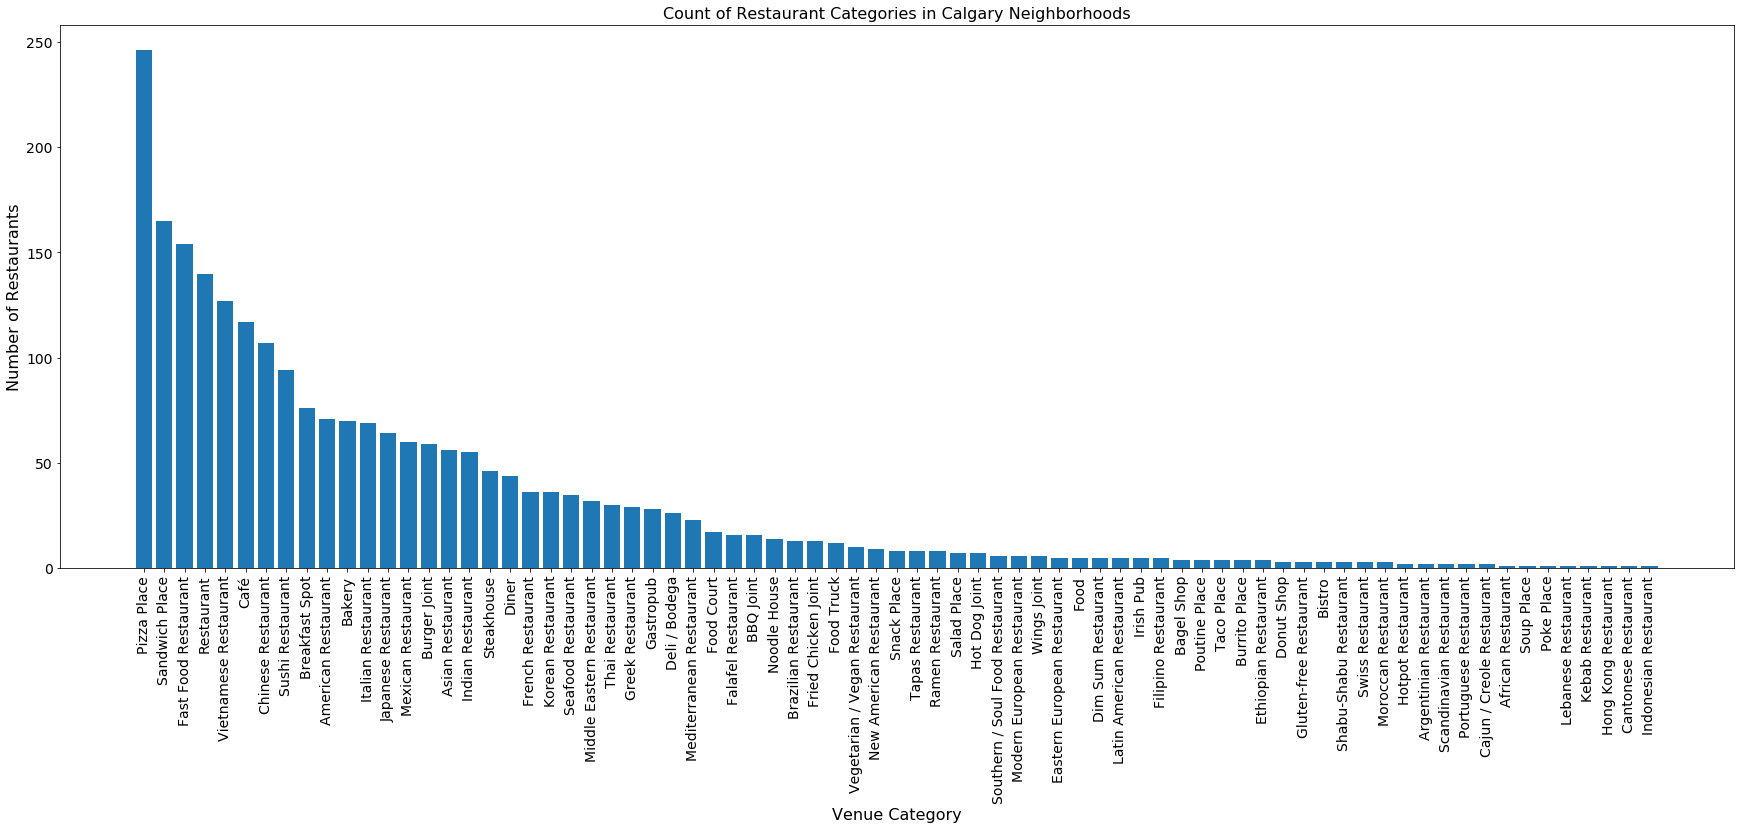

The Top 10 Most Common Restaurants in Calgary Are:  ['Pizza Place', 'Sandwich Place', 'Fast Food Restaurant', 'Restaurant', 'Vietnamese Restaurant', 'Café', 'Chinese Restaurant', 'Sushi Restaurant', 'Breakfast Spot', 'American Restaurant']
Venue Category
Pizza Place                    246
Sandwich Place                 165
Fast Food Restaurant           154
Restaurant                     140
Vietnamese Restaurant          127
Café                           117
Chinese Restaurant             107
Sushi Restaurant                94
Breakfast Spot                  76
American Restaurant             71
Bakery                          70
Italian Restaurant              69
Japanese Restaurant             64
Mexican Restaurant              60
Burger Joint                    59
Asian Restaurant                56
Indian Restaurant               55
Steakhouse                      46
Diner                           44
French Restaurant               36
Korean Restaurant               36
Seafood Re

In [28]:
cal_venues3 = cal_venues[['Neighborhood','Venue Category']].groupby(by='Venue Category').count()

cal_venues3['Neighborhood'] = cal_venues3['Neighborhood'].fillna(0)
cal_venues3 = cal_venues3.sort_values(by='Neighborhood', ascending=False)

x = np.arange(len(cal_venues3.index))

fig, ax = plt.subplots(figsize=(30,10))
plt.bar(x, cal_venues3['Neighborhood'])
plt.xticks(x, cal_venues3.index, rotation='vertical')
ax.tick_params(labelsize=14)
ax.set_title('Count of Restaurant Categories in Calgary Neighborhoods', fontsize=16)
ax.set_xlabel('Venue Category', fontsize=16)
ax.set_ylabel('Number of Restaurants', fontsize=16)
plt.show()

print("The Top 10 Most Common Restaurants in Calgary Are: ", list(cal_venues3.index)[0:10])
print(cal_venues3['Neighborhood'])

The next thing I look at is the distribution of median income of neighborhoods sorted by venue category. I do this using a box plot to identify any extreme values and outliers. Looking at the right hand side of the plot there are a few categories that have only 1 or 2 restaurants in the data set and the neighborhoods they are located in have a higher median income than most of the other neighborhoods in the data set. This could cause the results to be biased. It also looks like there are some extreme values particularily in the more common restaurant categories such as pizza places and fast food restaurants.

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Median Income')

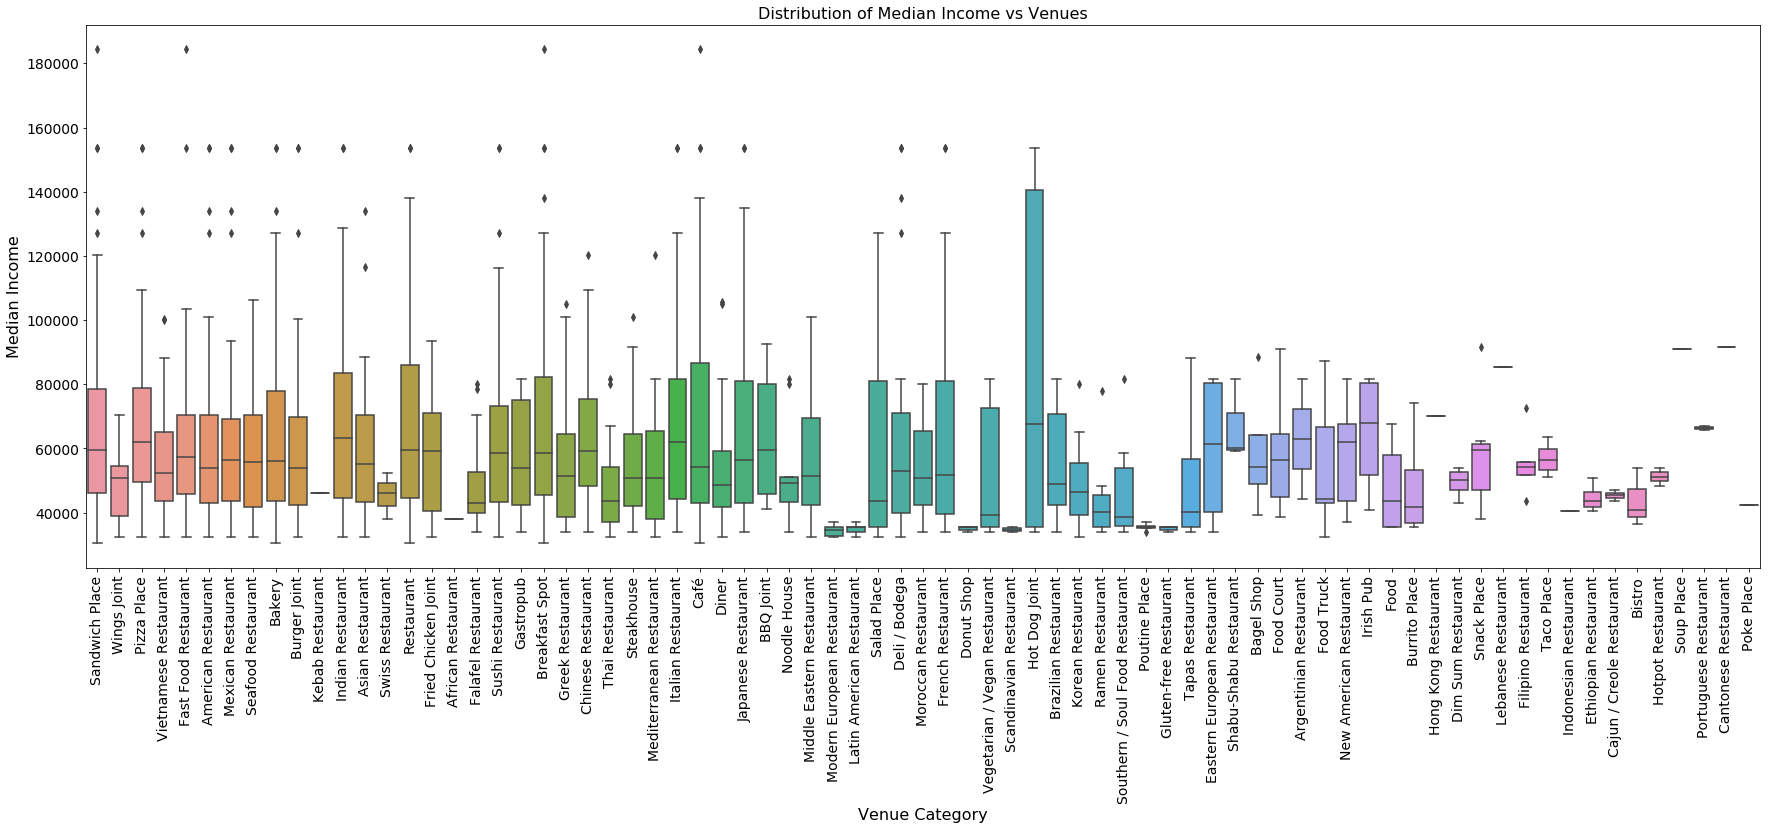

In [27]:
avg_income = cal_venues[['Neighborhood', 'Venue Category']]
avg_income.drop_duplicates(keep='first', inplace=True)
avg_income.set_index('Neighborhood', inplace=True)
avg_income = pd.merge(avg_income, cal_df, how='left', left_index=True, right_index=True)
avg_income = avg_income[['Venue Category', 'Med_Income']]

fig, ax = plt.subplots(figsize=(30,10))

sns.boxplot(x=avg_income['Venue Category'], y=avg_income['Med_Income'], ax = ax)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
ax.set_title('Distribution of Median Income vs Venues', fontsize=16)
ax.set_xlabel('Venue Category', fontsize=16)
ax.set_ylabel('Median Income', fontsize=16)

So since there are some outliers when looking at the income versus venue category, it may not be appropriate to base the results on this. Instead I look at the count of restaurants overall per neighborhood versus 4 variables from the data frame. Looking at the scatter plots it looks like there is a positive correlation between population density and number and restuarants and a negative correlation for median income, area, and number of dwellings.

Text(0, 0.5, 'Venue Count')

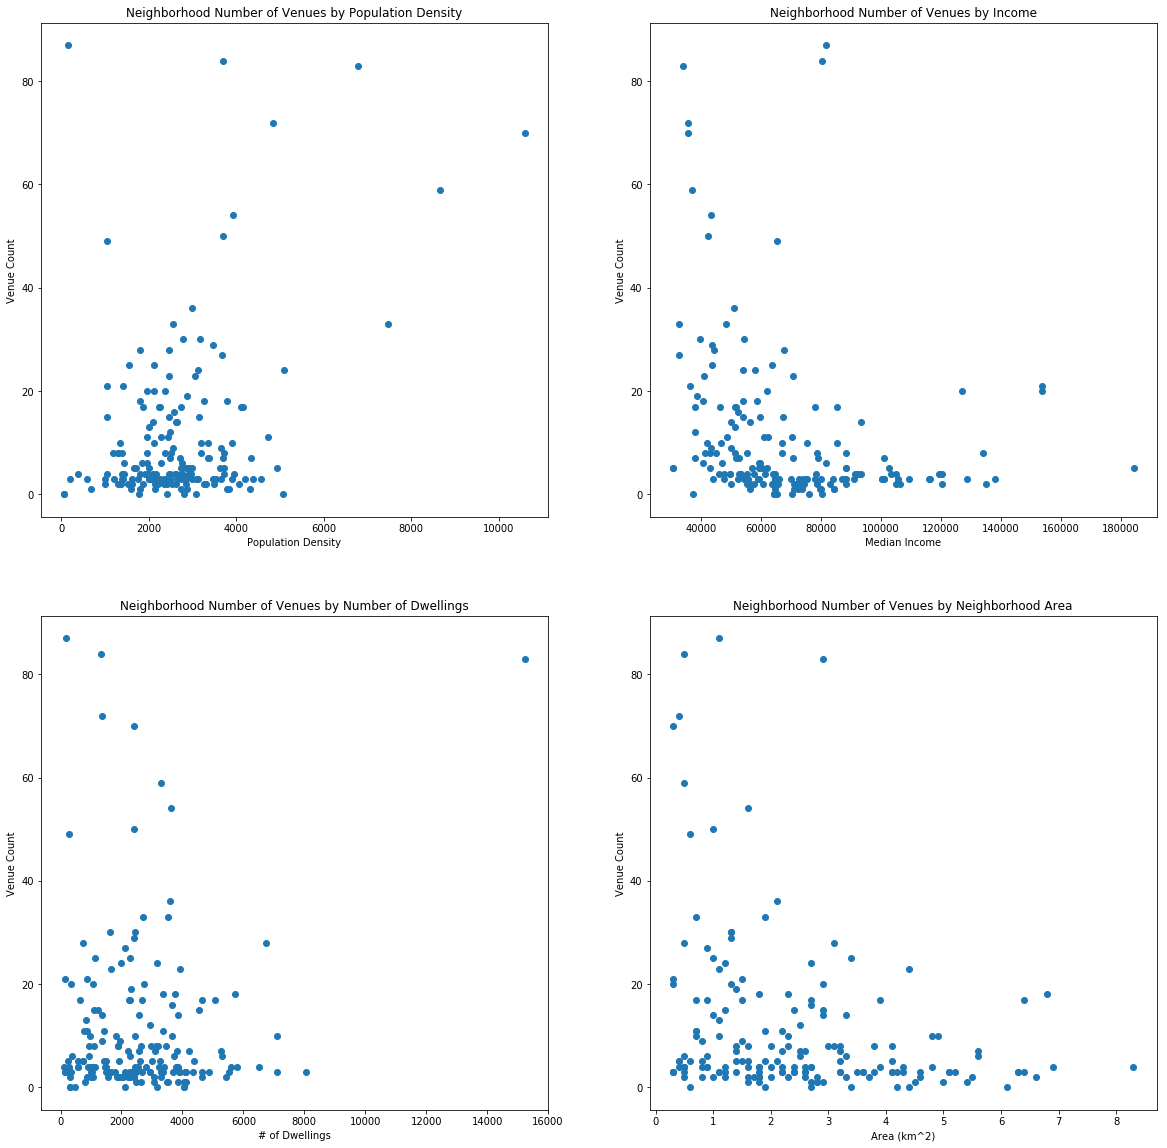

In [38]:
cal_venues2 = cal_venues[['Neighborhood','Venue Category']].groupby(by='Neighborhood').count()

cal_merged2 = cal_df.join(cal_venues2, on=cal_df.index)

cal_merged2['Venue Category'] = cal_merged2['Venue Category'].fillna(0)

fig, ax = plt.subplots(2, 2, figsize=(20, 20))

ax[0,0].scatter(cal_merged2['Pop_Density'], y=cal_merged2['Venue Category'])
ax[0,0].set_title('Neighborhood Number of Venues by Population Density')
ax[0,0].set_xlabel('Population Density')
ax[0,0].set_ylabel('Venue Count')

ax[0,1].scatter(cal_merged2['Med_Income'], y=cal_merged2['Venue Category'])
ax[0,1].set_title('Neighborhood Number of Venues by Income')
ax[0,1].set_xlabel('Median Income')
ax[0,1].set_ylabel('Venue Count')

ax[1,0].scatter(cal_merged2['Dwellings'], y=cal_merged2['Venue Category'])
ax[1,0].set_title('Neighborhood Number of Venues by Number of Dwellings')
ax[1,0].set_xlabel('# of Dwellings')
ax[1,0].set_ylabel('Venue Count')

ax[1,1].scatter(cal_merged2['Area'], y=cal_merged2['Venue Category'])
ax[1,1].set_title('Neighborhood Number of Venues by Neighborhood Area')
ax[1,1].set_xlabel('Area (km^2)')
ax[1,1].set_ylabel('Venue Count')

I choose to use population density and median income as the independent variables for the analysis because population density, area and number of dwellings are all dependent of one another and only one is necessary. If we look at the regression plots for these variables against the count of restaurants in each neighborhood we see that there is indeed a correlation. However, when we calculate the pearson coefficient and R value we see that it is a weak correlation with high certainty. A linear model may not be appropriate for this application.

Population Density vs. Number of Venues: Pearson Coefficient = 0.37722983128294924, R = 2.0976409444845465e-07
Median INcome vs. Number of Venues: Pearson Coefficient = -0.25840710790467636, R = 0.0004965106247343966


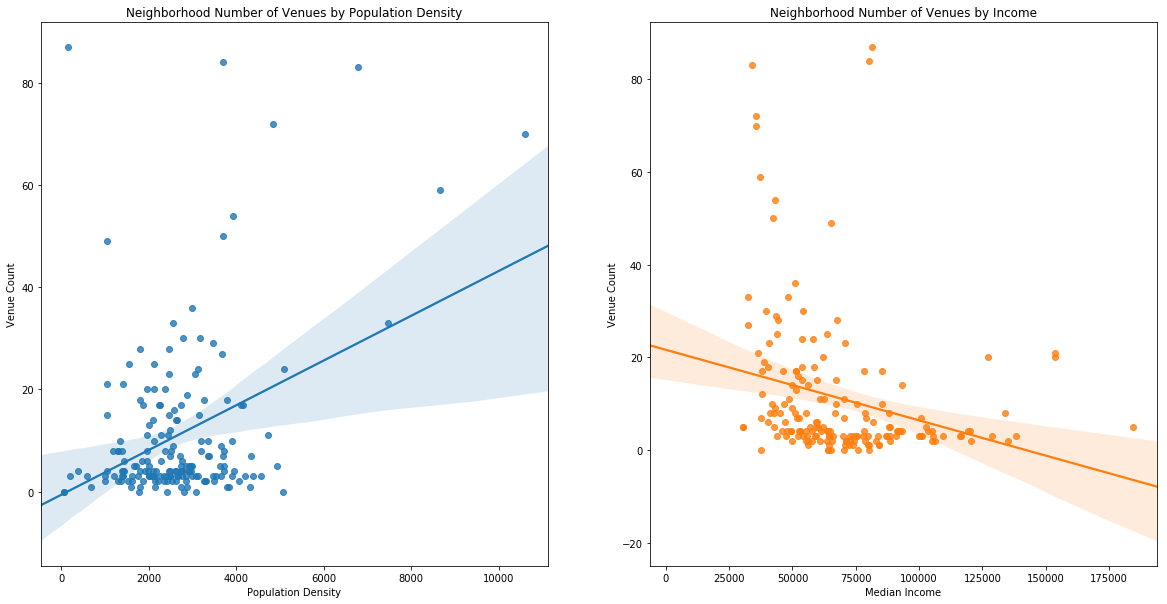

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.regplot(x=cal_merged2['Pop_Density'], y=cal_merged2['Venue Category'], ax=ax[0])
ax[0].set_title('Neighborhood Number of Venues by Population Density')
ax[0].set_xlabel('Population Density')
ax[0].set_ylabel('Venue Count')
sns.regplot(x=cal_merged2['Med_Income'], y=cal_merged2['Venue Category'], ax=ax[1])
ax[1].set_title('Neighborhood Number of Venues by Income')
ax[1].set_xlabel('Median Income')
ax[1].set_ylabel('Venue Count')

coef1, p1 = stats.pearsonr(cal_merged2['Pop_Density'], cal_merged2['Venue Category'])
coef2, p2 = stats.pearsonr(cal_merged2['Med_Income'], cal_merged2['Venue Category'])
print('Population Density vs. Number of Venues: Pearson Coefficient = {}, R = {}'.format(coef1, p1))
print('Median INcome vs. Number of Venues: Pearson Coefficient = {}, R = {}'.format(coef2, p2))

Looking at the residual plots, it is clear that a linear model will not work with this data. Another approach is needed. 

Text(0, 0.5, 'Venue Count')

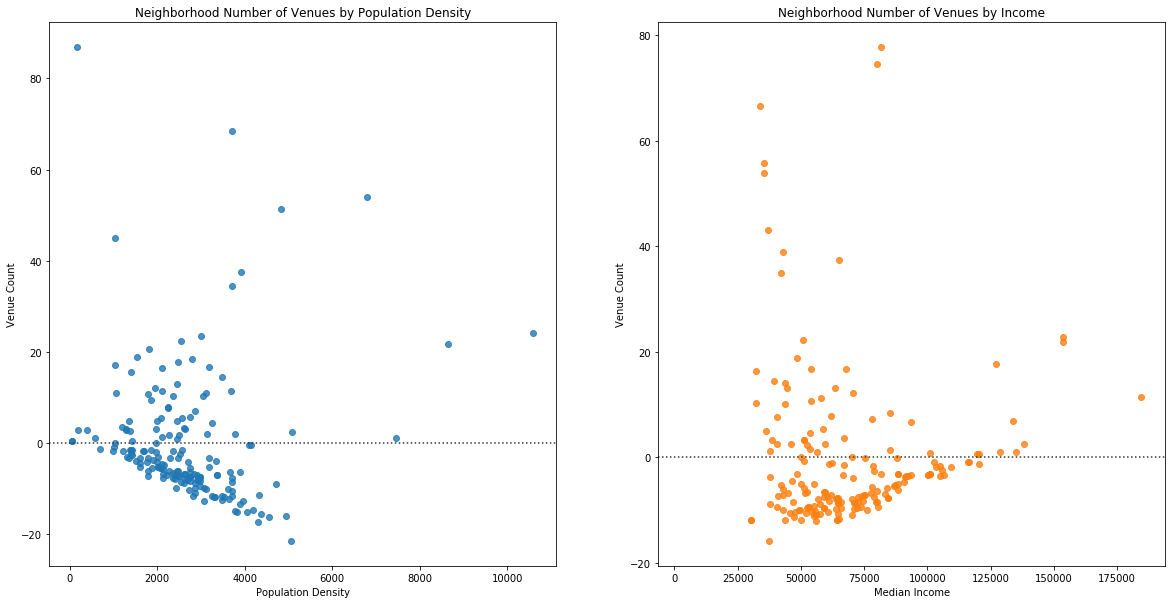

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.residplot(x=cal_merged2['Pop_Density'], y=cal_merged2['Venue Category'], ax=ax[0])
ax[0].set_title('Neighborhood Number of Venues by Population Density')
ax[0].set_xlabel('Population Density')
ax[0].set_ylabel('Venue Count')
sns.residplot(x=cal_merged2['Med_Income'], y=cal_merged2['Venue Category'], ax=ax[1])
ax[1].set_title('Neighborhood Number of Venues by Income')
ax[1].set_xlabel('Median Income')
ax[1].set_ylabel('Venue Count')

Next I plot the features against the number of restaurants on a 3D axis to see the influence they have when looked at together. It seems that the neighborhoods with the highest amount of restaurants have the lowest income and highest population density.

Text(0.5, 0, 'Number of Venues')

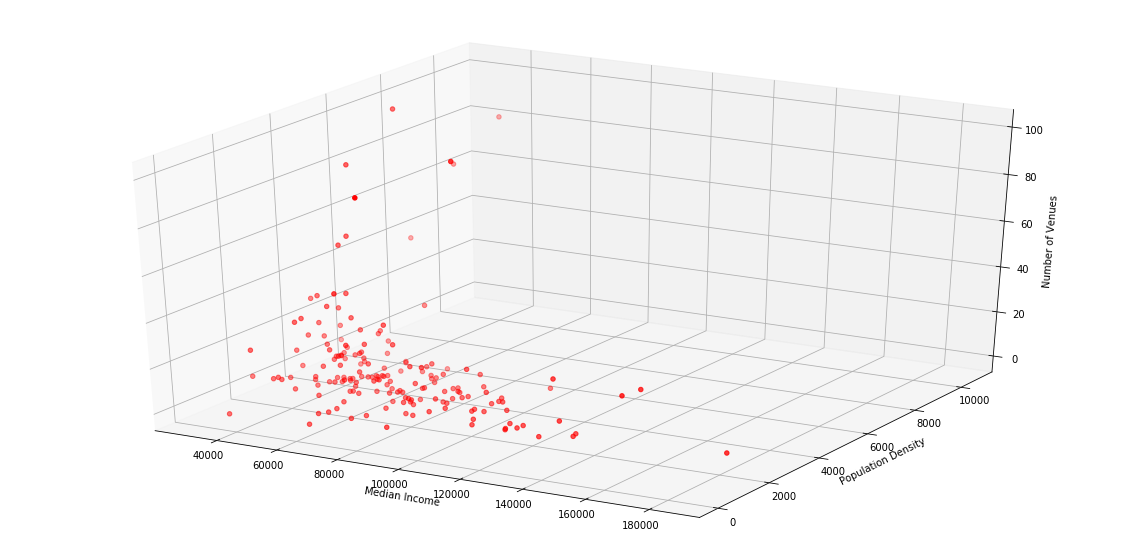

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

X = cal_merged2['Med_Income']
Y = cal_merged2['Pop_Density']
Z = cal_merged2['Venue Category']

ax.scatter(X, Y, Z, color='red')

ax.set_xlabel('Median Income')
ax.set_ylabel('Population Density')
ax.set_zlabel('Number of Venues')


### Clustering

In the next few steps I use a K Means model to assign each neighborhood to clusters based on common venues, median income, and population density. The outcome I am hoping for is that the model will asign the neighborhoods to 3 clusters:

- High Population Density / Low Income
- Medium Population Density / Median Income
- Low Population Density / High Income

I am also hoping that there will be a noticeable difference in common venues between the clusters. 

I use a min max scaler to scale the values before fitting them to the model. 

In [15]:
kclusters = 3

cal_grouped.set_index('Neighborhood', inplace=True)

cal_grouped_clustering = pd.merge(cal_df, cal_grouped, how='left', left_index=True, right_index=True)

cal_grouped_clustering.dropna(inplace=True)
cal_grouped_clustering.drop(columns=['Med_Age', 'Population', 'Dwellings', 'Quadrant', 'Med_Home_Price', 'Area', 'Lat', 'Lng'], inplace=True)

from sklearn import preprocessing

scaled = preprocessing.MinMaxScaler().fit_transform(cal_grouped_clustering)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scaled)
kmeans.labels_

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cal_merged = cal_df

cal_merged = cal_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'),
                                     on=cal_merged.index)

cal_merged.dropna(inplace=True)
cal_merged = cal_merged.astype({'Cluster Labels':int})
cal_merged[['Cluster Labels']].head()



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Cluster Labels
Community,
Abbeydale,1
Acadia,1
Albert Park/Radisson Heights,1
Altadore,2
Applewood Park,1


Plotting the clusters on a map we can see that they are fairly evenly distributed around the city. 

In [16]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cal_merged['Lat'], cal_merged['Lng'],
                                  cal_merged.index, cal_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

In cluster 0 there are 36 neighborhoods. The mean income is about $96,000 and the mean population density is 1952. Looking at the venue categories it seems that there is a wide variety.

In [17]:
print(cal_merged[cal_merged['Cluster Labels'] == 0].describe())
cluster_0 = cal_merged[cal_merged['Cluster Labels'] == 0]
cluster_0.reset_index(inplace=True)
cluster_0

          Med_Income   Med_Age    Population    Dwellings  Med_Home_Price  \
count      36.000000  36.00000     36.000000    36.000000    3.600000e+01   
mean    95629.055556  41.75000   4966.388889  1885.444444    8.043367e+05   
std     34497.497710   6.99949   5173.067177  1789.183077    3.299633e+05   
min     30411.000000  30.00000    243.000000   110.000000    4.111000e+05   
25%     67232.250000  38.00000   1552.000000   582.250000    5.287250e+05   
50%     91886.500000  42.00000   2680.000000  1240.500000    7.500075e+05   
75%    119691.000000  46.00000   6312.750000  2486.000000    9.000000e+05   
max    184383.000000  58.00000  21386.000000  7097.000000    1.701000e+06   

            Area  Pop_Density        Lat         Lng  Cluster Labels  
count  36.000000    36.000000  36.000000   36.000000            36.0  
mean    2.311111  1951.638889  51.004888 -114.107158             0.0  
std     2.064223   789.150179   0.062091    0.068513             0.0  
min     0.300000   197

,Community,Med_Income,Med_Age,Population,Dwellings,Quadrant,Med_Home_Price,Area,Pop_Density,Lat,Lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aspen Woods,133939,32,7496,2657,SW,895000,3.8,1387.1,51.045190,-114.211600,0,American Restaurant,Asian Restaurant,Pizza Place,Bakery,Japanese Restaurant
1,Auburn Bay,84350,30,11127,4130,SE,519900,4.5,1598.4,50.889760,-113.963970,0,Breakfast Spot,Wings Joint,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant
2,Bayview,184383,49,669,248,SW,1125000,0.4,1705.0,50.973460,-114.108240,0,Café,Breakfast Spot,Fast Food Restaurant,Sandwich Place,Donut Shop
3,Bel-Aire,138124,51,434,158,SW,1701000,0.3,1413.3,50.999630,-114.089790,0,Breakfast Spot,Deli / Bodega,Restaurant,Café,Food Court
4,Britannia,120387,46,722,312,SW,1499000,0.5,1606.0,51.013890,-114.085700,0,Restaurant,Café,French Restaurant,Wings Joint,Food
5,Cedarbrae,62063,39,6271,2609,SW,411100,2.1,2970.0,50.956190,-114.129550,0,Pizza Place,Vietnamese Restaurant,Sushi Restaurant,Sandwich Place,Fast Food Restaurant
6,Chinook Park,88357,47,1708,589,SW,688500,0.6,2845.0,50.982690,-114.089450,0,Café,Japanese Restaurant,Bagel Shop,Bakery,Restaurant
7,Christie Park,102664,49,2217,728,SW,850000,0.8,2745.0,51.040330,-114.178580,0,Chinese Restaurant,Japanese Restaurant,Sandwich Place,Café,Seafood Restaurant
8,Cranston,91320,32,15354,5795,SE,474000,8.3,1428.6,50.880400,-113.979970,0,Café,Pizza Place,Sandwich Place,Sushi Restaurant,Food
9,Discovery Ridge,128844,38,4462,1650,SW,800000,3.6,1208.3,51.012200,-114.201810,0,Indian Restaurant,Café,Food Court,Eastern European Restaurant,Ethiopian Restaurant


In cluster 1 there are 92 neighborhoods. The mean income is about $68,000 and the mean population density is 2686. For the venues the results are similar to cluster 0 although there is a high occurance of pizza places. 

In [18]:
print(cal_merged[cal_merged['Cluster Labels'] == 1].describe())
cluster_1 = cal_merged[cal_merged['Cluster Labels'] == 1]
cluster_1.reset_index(inplace=True)
cluster_1

          Med_Income    Med_Age    Population    Dwellings  Med_Home_Price  \
count      92.000000  92.000000     92.000000    92.000000    9.200000e+01   
mean    67855.510870  38.565217   7787.663043  2924.543478    5.061139e+05   
std     19494.202585   5.148998   4576.650556  1576.954914    1.366076e+05   
min     30411.000000  29.000000    351.000000   181.000000    3.050000e+05   
25%     52466.500000  35.000000   4303.750000  1832.000000    4.207500e+05   
50%     65207.500000  38.000000   7684.500000  2965.000000    4.700000e+05   
75%     79842.000000  42.000000  10872.250000  3844.250000    5.862250e+05   
max    120196.000000  52.000000  25130.000000  8063.000000    1.055000e+06   

            Area  Pop_Density        Lat         Lng  Cluster Labels  
count  92.000000    92.000000  92.000000   92.000000            92.0  
mean    2.850000  2686.345652  51.047061 -114.071376             1.0  
std     1.591357   957.118086   0.083319    0.082506             0.0  
min     0.300

,Community,Med_Income,Med_Age,Population,Dwellings,Quadrant,Med_Home_Price,Area,Pop_Density,Lat,Lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abbeydale,55345,34,6071,2031,SE,305000,1.7,3480.6,51.059760,-113.925460,1,Wings Joint,Pizza Place,Sandwich Place,Food,Eastern European Restaurant
1,Acadia,46089,42,10969,5067,SE,447000,3.9,2744.9,50.972270,-114.058430,1,Fast Food Restaurant,American Restaurant,Pizza Place,Sandwich Place,Burger Joint
2,Albert Park/Radisson Heights,38019,37,6529,2936,SE,349900,2.5,2493.6,51.042000,-113.996830,1,Pizza Place,Vietnamese Restaurant,Asian Restaurant,Fried Chicken Joint,Falafel Restaurant
3,Applewood Park,65724,33,6864,2228,SE,380000,1.6,4061.3,51.045440,-113.925130,1,Pizza Place,Vietnamese Restaurant,Fast Food Restaurant,Food Court,Eastern European Restaurant
4,Arbour Lake,70590,41,10987,3931,NW,490500,4.4,2462.7,51.133510,-114.203360,1,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Café,Sandwich Place
5,Beddington Heights,56881,37,11867,4371,NW,385000,3.2,3620.3,51.130900,-114.078700,1,Pizza Place,Vietnamese Restaurant,Italian Restaurant,Chinese Restaurant,Sandwich Place
6,Bonavista Downs,81761,42,956,370,SE,470000,0.5,1850.0,50.935390,-114.028710,1,Fast Food Restaurant,Chinese Restaurant,BBQ Joint,Shabu-Shabu Restaurant,Wings Joint
7,Bowness,40468,40,11611,5300,NW,420000,5.6,1966.4,51.089350,-114.199320,1,Fast Food Restaurant,Pizza Place,Greek Restaurant,Sandwich Place,Café
8,Braeside,64691,39,5960,2548,SW,439500,2.0,2970.0,50.956510,-114.104790,1,Pizza Place,Sandwich Place,Sushi Restaurant,Seafood Restaurant,Fast Food Restaurant
9,Bridgeland/Riverside,44363,42,11924,6752,NE,612500,3.1,1804.5,51.052270,-114.044320,1,Italian Restaurant,Café,Pizza Place,Food Truck,Diner


In cluster 2 there are 45 neighborhoods. The mean income is about $52,000 and the mean population density is 3229. Once again the venue categories seem to be quite scattered.

In [19]:
print(cal_merged[cal_merged['Cluster Labels'] == 2].describe())
cluster_2 = cal_merged[cal_merged['Cluster Labels'] == 2]
cluster_2.reset_index(inplace=True)
cluster_2

         Med_Income    Med_Age    Population     Dwellings  Med_Home_Price  \
count     45.000000  45.000000     45.000000     45.000000       45.000000   
mean   51526.622222  37.555556   4952.866667   2455.466667   635332.844444   
std    13016.873021   5.224747   3591.079121   2266.605157   170170.892668   
min    32409.000000  29.000000    632.000000    278.000000   342000.000000   
25%    42795.000000  34.000000   2336.000000   1129.000000   520000.000000   
50%    51221.000000  37.000000   4104.000000   2250.000000   622000.000000   
75%    59502.000000  40.000000   6357.000000   3177.000000   738500.000000   
max    91623.000000  56.000000  21357.000000  15243.000000   999000.000000   

            Area   Pop_Density        Lat         Lng  Cluster Labels  
count  45.000000     45.000000  45.000000   45.000000            45.0  
mean    1.706667   3228.713333  51.033970 -114.083722             2.0  
std     1.209320   1959.570137   0.052858    0.048019             0.0  
min     0

,Community,Med_Income,Med_Age,Population,Dwellings,Quadrant,Med_Home_Price,Area,Pop_Density,Lat,Lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Altadore,53786,37,9518,4537,SW,925000,2.9,3143.4,51.01601,-114.10558,2,Sushi Restaurant,Sandwich Place,Greek Restaurant,Breakfast Spot,Chinese Restaurant
1,Banff Trail,49996,31,4204,1952,NW,668000,1.5,2558.0,51.07472,-114.11297,2,Pizza Place,Restaurant,Breakfast Spot,Steakhouse,Fast Food Restaurant
2,Bankview,32474,32,5416,3536,SW,610000,0.7,7458.6,51.03412,-114.10044,2,Pizza Place,Vietnamese Restaurant,Mexican Restaurant,Sandwich Place,Fast Food Restaurant
3,Beltline,33901,33,21357,15243,SW,525289,2.9,6786.6,51.04161,-114.07908,2,Restaurant,Japanese Restaurant,Pizza Place,Sandwich Place,Burger Joint
4,Brentwood,56305,42,6206,2585,NW,560000,2.9,2089.3,51.09533,-114.13179,2,Fast Food Restaurant,Sandwich Place,Japanese Restaurant,Asian Restaurant,Vietnamese Restaurant
5,Cambrian Heights,59522,40,2090,920,NW,579900,0.9,2287.8,51.08323,-114.08366,2,Indian Restaurant,Vietnamese Restaurant,Asian Restaurant,Bakery,Sandwich Place
6,Castleridge,57923,33,6396,1983,NE,408000,1.2,5080.0,51.10634,-113.96027,2,Fast Food Restaurant,Indian Restaurant,Pizza Place,Asian Restaurant,Vietnamese Restaurant
7,Cliff Bungalow,35576,32,2049,1348,SW,885000,0.4,4840.0,51.03427,-114.07341,2,Pizza Place,Restaurant,Café,French Restaurant,Vietnamese Restaurant
8,Crescent Heights,43123,37,6235,3615,NE,560000,1.6,3919.4,51.05976,-114.06132,2,Chinese Restaurant,Café,Restaurant,Vietnamese Restaurant,Sushi Restaurant
9,Eau Claire,80210,56,1886,1321,SW,644489,0.5,3702.0,51.05001,-114.07005,2,Restaurant,Chinese Restaurant,Steakhouse,Café,American Restaurant


Below are the box plots for median income and population density for each cluster. The results are somewhat what we were hoping for. Cluster 0 has the highest income and then it decreases as the cluster number increases. The opposite is true for population density however there is not much of a difference between cluster 1 and 2.

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

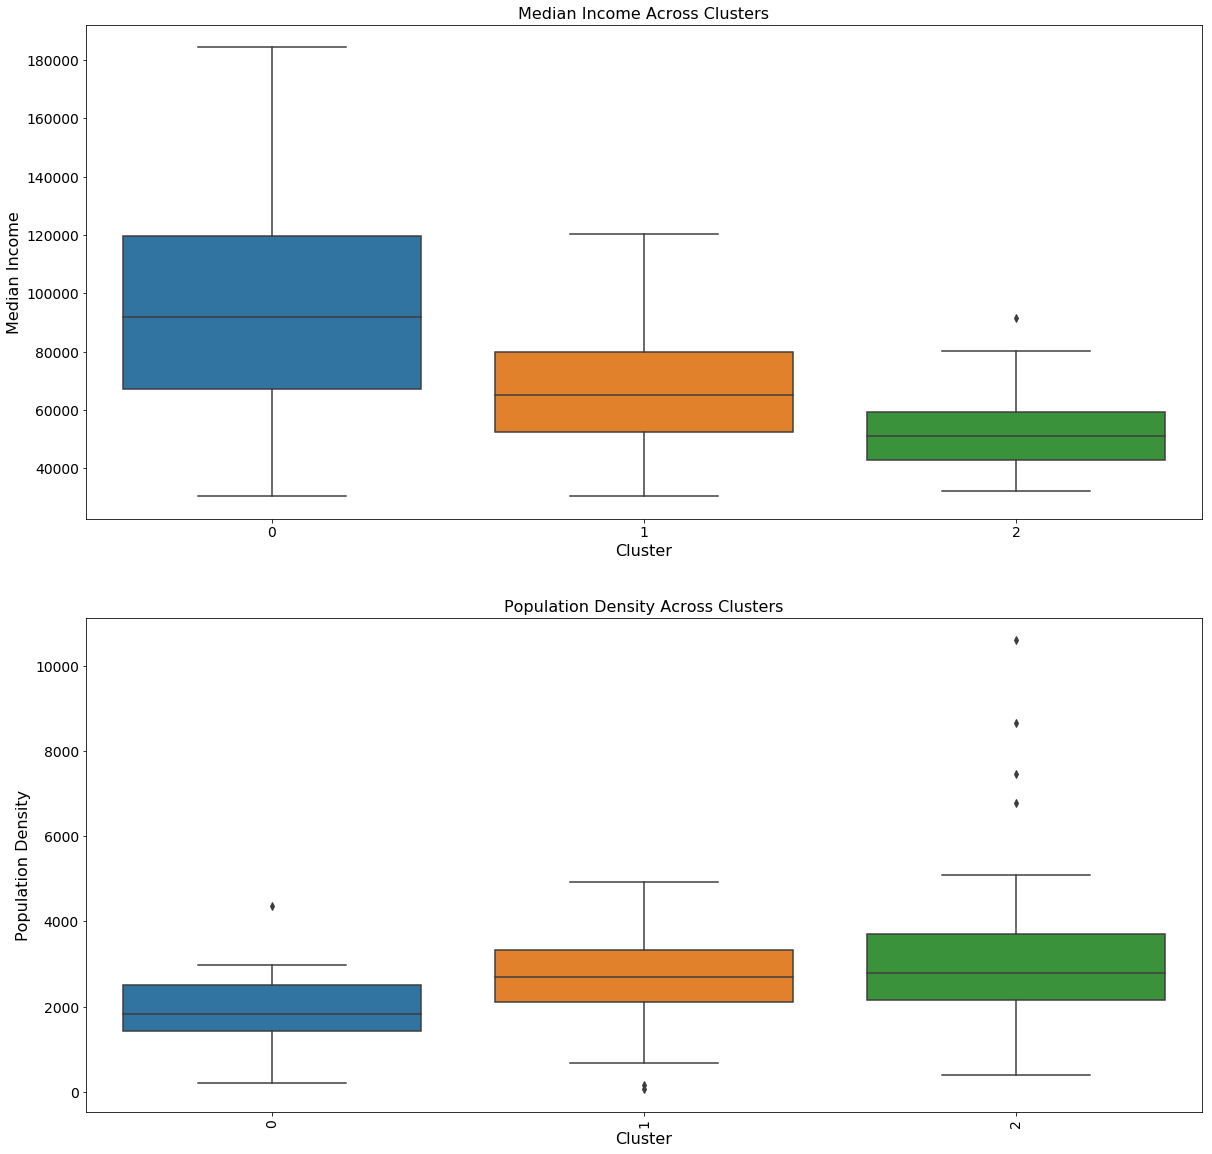

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.boxplot(x=cal_merged['Cluster Labels'], y=cal_merged['Med_Income'], ax = ax[0])
ax[0].tick_params(labelsize=14)
ax[0].set_title('Median Income Across Clusters', fontsize=16)
ax[0].set_xlabel('Cluster', fontsize=16)
ax[0].set_ylabel('Median Income', fontsize=16)

sns.boxplot(x=cal_merged['Cluster Labels'], y=cal_merged['Pop_Density'], ax = ax[1])
ax[1].tick_params(labelsize=14)
ax[1].set_title('Population Density Across Clusters', fontsize=16)
ax[1].set_xlabel('Cluster', fontsize=16)
ax[1].set_ylabel('Population Density', fontsize=16)

plt.xticks(rotation='vertical')

I make a bar chart of the counts of venue categories per cluster. 

In cluster 0 the top 5 venue categories in order are:

1. Cafe's
2. Pizza Places
3. Restaurants
4. Sandwich Places
5. Breakfast Spots

In cluster 1 the top 5 venue categories in order are:

1. Pizza Places
2. Fast Food Restaurants
3. Sandwich Places
4. Chinese Restaurants
5. Vietnamese Restaurants

In cluster 2 the top 5 venue categories in order are:

1. Pizza Places
2. Restaurants
3. Vietnamese Restaurants
4. Fast Food Restaurants
5. Sandwich Places

Unfortunately there is a lot of overlap in the venue categories when comparing clusters so the model did not do a good job of separating them from one another. 

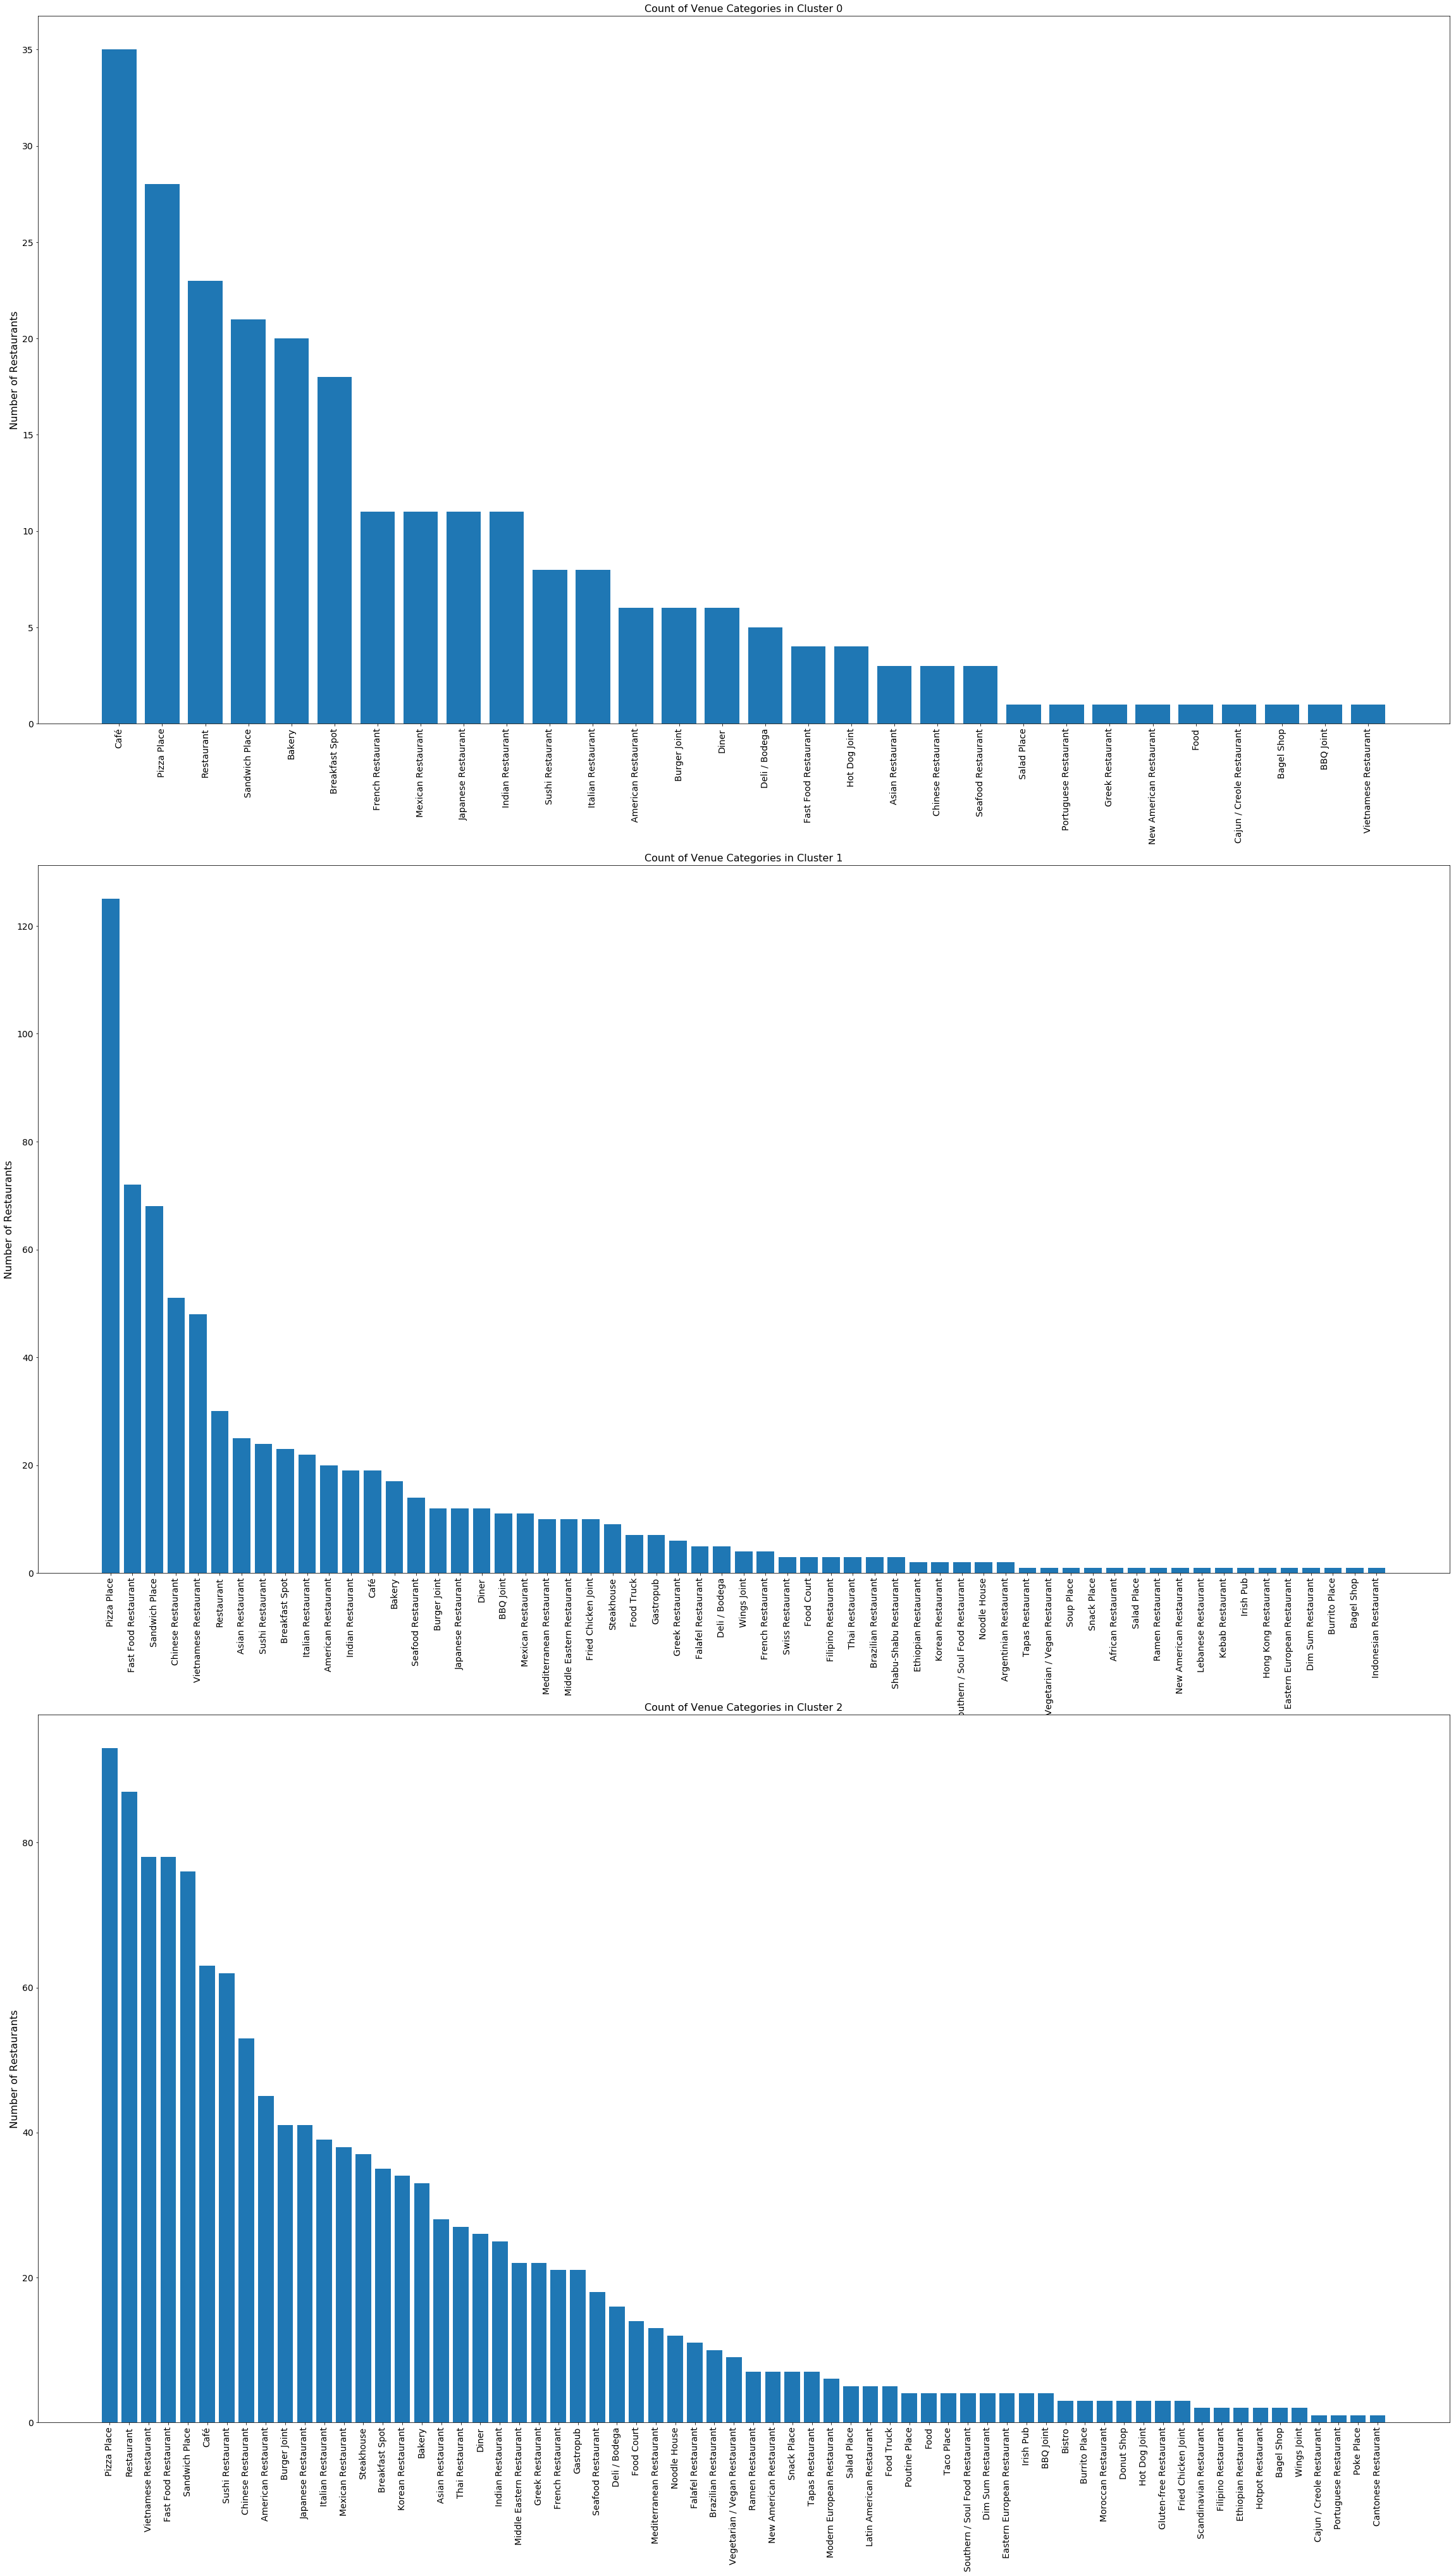

In [21]:
cluster_0_venues = cal_venues.set_index('Neighborhood').loc[cluster_0['Community']]
cluster_1_venues = cal_venues.set_index('Neighborhood').loc[cluster_1['Community']]
cluster_2_venues = cal_venues.set_index('Neighborhood').loc[cluster_2['Community']]

cluster_0_grouped = cluster_0_venues[['Venue Category', 'Venue']].groupby('Venue Category').count()
cluster_1_grouped = cluster_1_venues[['Venue Category', 'Venue']].groupby('Venue Category').count()
cluster_2_grouped = cluster_2_venues[['Venue Category', 'Venue']].groupby('Venue Category').count()

cluster_0_grouped.sort_values(by='Venue', ascending=False, inplace=True)
cluster_1_grouped.sort_values(by='Venue', ascending=False, inplace=True)
cluster_2_grouped.sort_values(by='Venue', ascending=False, inplace=True)

cluster_0_grouped.head()


x1 = np.arange(len(cluster_0_grouped.index))
x2 = np.arange(len(cluster_1_grouped.index))
x3 = np.arange(len(cluster_2_grouped.index))

fig, ax = plt.subplots(3,1, figsize=(40,70))

ax[0].bar(x1, cluster_0_grouped['Venue'])
ax[0].set_xticks(x1)
ax[0].set_xticklabels(cluster_0_grouped.index, rotation='vertical')
ax[0].tick_params(labelsize=14)
ax[0].set_title('Count of Venue Categories in Cluster 0', fontsize=16)
ax[0].set_ylabel('Number of Restaurants', fontsize=16)

ax[1].bar(x2, cluster_1_grouped['Venue'])
ax[1].set_xticks(x2)
ax[1].set_xticklabels(cluster_1_grouped.index, rotation='vertical')
ax[1].tick_params(labelsize=14)
ax[1].set_title('Count of Venue Categories in Cluster 1', fontsize=16)
ax[1].set_ylabel('Number of Restaurants', fontsize=16)

ax[2].bar(x3, cluster_2_grouped['Venue'])
ax[2].set_xticks(x3)
ax[2].set_xticklabels(cluster_2_grouped.index, rotation='vertical')
ax[2].tick_params(labelsize=14)
ax[2].set_title('Count of Venue Categories in Cluster 2', fontsize=16)
ax[2].set_ylabel('Number of Restaurants', fontsize=16)


plt.show()

To try and get better results from clustering, I remove restaurant categories equal to Pizza Place and Restaurant.

Pizza places are the most common restaurant category in the city and are found in every part of the city regardless of income or population density. I chose to remove the category "Restaurant" because it is too general and can refer to any kind of restaurant.

In [29]:
cal_venues = cal_venues[cal_venues['Venue Category'] != 'Pizza Place']
cal_venues = cal_venues[cal_venues['Venue Category'] != 'Restaurant']
cal_venues.shape

(1971, 7)

I again convert the venue categories to one hot encoding. This time I scale the data with a standard scaler to see if I can get better results. 

In [30]:
cal_onehot = pd.get_dummies(cal_venues[['Venue Category']], prefix='', prefix_sep='')
cal_onehot['Neighborhood'] = cal_venues['Neighborhood']

fixed_columns = [cal_onehot.columns[-1]] + list(cal_onehot.columns[:-1])
cal_onehot = cal_onehot[fixed_columns]

cal_grouped = cal_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cal_grouped['Neighborhood']

for ind in np.arange(cal_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cal_grouped.iloc[ind, :], num_top_venues)


kclusters = 3

cal_grouped.set_index('Neighborhood', inplace=True)

cal_grouped_clustering = pd.merge(cal_df, cal_grouped, how='left', left_index=True, right_index=True)

cal_grouped_clustering.dropna(inplace=True)
cal_grouped_clustering.drop(columns=['Med_Age', 'Population', 'Dwellings', 'Quadrant', 'Med_Home_Price', 'Area', 'Lat', 'Lng'], inplace=True)

from sklearn import preprocessing

scaled = preprocessing.StandardScaler().fit_transform(cal_grouped_clustering)

kmeans = KMeans(init = 'k-means++', n_init=12, n_clusters=kclusters, random_state=0).fit(scaled)
kmeans.labels_

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
# neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

cal_merged = cal_df

cal_merged = cal_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'),
                                     on=cal_merged.index)

cal_merged.dropna(inplace=True)
cal_merged = cal_merged.astype({'Cluster Labels':int})

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


I create the map again with the new clusters. The clusters are less evenly distributed this time and one cluster only has 5 neighborhoods in it.

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cal_merged['Lat'], cal_merged['Lng'],
                                  cal_merged.index, cal_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

Cluster 0 has 5 neighborhoods, a mean income of about $35,000 and a population density of 7667. The most common restaurants are vietnamese restaurants, mexican restaurants, cafe's, and japanese restaurants.

In [32]:
print(cal_merged[cal_merged['Cluster Labels'] == 0].describe())
cluster_0 = cal_merged[cal_merged['Cluster Labels'] == 0]
cluster_0.reset_index(inplace=True)
cluster_0

         Med_Income  Med_Age    Population     Dwellings  Med_Home_Price  \
count      5.000000      5.0      5.000000      5.000000        5.000000   
mean   34912.200000     33.0   7298.200000   5168.200000   680557.800000   
std     1758.423214      1.0   7957.269488   5697.266643   151340.004474   
min    32474.000000     32.0   2049.000000   1348.000000   525289.000000   
25%    33901.000000     32.0   3319.000000   2414.000000   590000.000000   
50%    35570.000000     33.0   4350.000000   3300.000000   610000.000000   
75%    35576.000000     34.0   5416.000000   3536.000000   792500.000000   
max    37040.000000     34.0  21357.000000  15243.000000   885000.000000   

           Area   Pop_Density        Lat         Lng  Cluster Labels  
count  5.000000      5.000000   5.000000    5.000000             5.0  
mean   0.960000   7667.040000  51.035426 -114.080820             0.0  
std    1.094532   2143.550892   0.003490    0.012143             0.0  
min    0.300000   4840.000000  

,Community,Med_Income,Med_Age,Population,Dwellings,Quadrant,Med_Home_Price,Area,Pop_Density,Lat,Lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bankview,32474,32,5416,3536,SW,610000,0.7,7458.6,51.03412,-114.10044,0,Vietnamese Restaurant,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Indian Restaurant
1,Beltline,33901,33,21357,15243,SW,525289,2.9,6786.6,51.04161,-114.07908,0,Japanese Restaurant,Middle Eastern Restaurant,Sandwich Place,Diner,Vietnamese Restaurant
2,Cliff Bungalow,35576,32,2049,1348,SW,885000,0.4,4840.0,51.03427,-114.07341,0,Café,Vietnamese Restaurant,Burger Joint,French Restaurant,Japanese Restaurant
3,Lower Mount Royal,35570,34,3319,2414,SW,792500,0.3,10600.0,51.03306,-114.08237,0,Vietnamese Restaurant,Mexican Restaurant,Japanese Restaurant,Café,Diner
4,Mission,37040,34,4350,3300,SW,590000,0.5,8650.0,51.03407,-114.06880,0,Café,French Restaurant,Bakery,Sandwich Place,Italian Restaurant


Cluster 1 has 56 neighborhoods, a mean income of about $56,000 and a mean population density of 2821. Some of the common restaurants include fast food restaurants, vietnamese restaurants, chinese restaurants, and sandwich places among others. 

In [33]:
print(cal_merged[cal_merged['Cluster Labels'] == 1].describe())
cluster_1 = cal_merged[cal_merged['Cluster Labels'] == 1]
cluster_1.reset_index(inplace=True)
cluster_1

          Med_Income    Med_Age    Population    Dwellings  Med_Home_Price  \
count      56.000000  56.000000     56.000000    56.000000       56.000000   
mean    56035.446429  38.000000   6419.964286  2660.053571   546954.910714   
std     14787.712537   4.089899   3805.087365  1407.506828   190570.919835   
min     32409.000000  31.000000    956.000000   370.000000   308500.000000   
25%     46041.250000  35.000000   3429.750000  1471.250000   390000.000000   
50%     53477.000000  37.500000   6220.500000  2453.500000   533500.000000   
75%     61296.250000  41.000000   8935.750000  3676.000000   621250.000000   
max    103357.000000  49.000000  16941.000000  5738.000000   999000.000000   

            Area  Pop_Density        Lat         Lng  Cluster Labels  
count  56.000000    56.000000  56.000000   56.000000            56.0  
mean    2.175000  2821.300000  51.043504 -114.067158             1.0  
std     1.224485   858.045806   0.059095    0.068843             0.0  
min     0.500

,Community,Med_Income,Med_Age,Population,Dwellings,Quadrant,Med_Home_Price,Area,Pop_Density,Lat,Lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Acadia,46089,42,10969,5067,SE,447000,3.9,2744.9,50.97227,-114.05843,1,Fast Food Restaurant,American Restaurant,Sandwich Place,Indian Restaurant,Asian Restaurant
1,Albert Park/Radisson Heights,38019,37,6529,2936,SE,349900,2.5,2493.6,51.04200,-113.99683,1,Asian Restaurant,Vietnamese Restaurant,Indian Restaurant,Sandwich Place,Bakery
2,Altadore,53786,37,9518,4537,SW,925000,2.9,3143.4,51.01601,-114.10558,1,Sushi Restaurant,Greek Restaurant,Breakfast Spot,Sandwich Place,Vietnamese Restaurant
3,Applewood Park,65724,33,6864,2228,SE,380000,1.6,4061.3,51.04544,-113.92513,1,Vietnamese Restaurant,Fast Food Restaurant,Diner,Eastern European Restaurant,Ethiopian Restaurant
4,Banff Trail,49996,31,4204,1952,NW,668000,1.5,2558.0,51.07472,-114.11297,1,Noodle House,Thai Restaurant,Vietnamese Restaurant,BBQ Joint,Steakhouse
5,Beddington Heights,56881,37,11867,4371,NW,385000,3.2,3620.3,51.13090,-114.07870,1,Vietnamese Restaurant,Chinese Restaurant,Italian Restaurant,Sandwich Place,Fast Food Restaurant
6,Bonavista Downs,81761,42,956,370,SE,470000,0.5,1850.0,50.93539,-114.02871,1,Fast Food Restaurant,Chinese Restaurant,BBQ Joint,Shabu-Shabu Restaurant,Wings Joint
7,Brentwood,56305,42,6206,2585,NW,560000,2.9,2089.3,51.09533,-114.13179,1,Fast Food Restaurant,Sandwich Place,Japanese Restaurant,Vietnamese Restaurant,Asian Restaurant
8,Bridlewood,70477,32,12588,4205,SW,425500,3.2,3698.4,50.89983,-114.10943,1,Wings Joint,Sushi Restaurant,Falafel Restaurant,Sandwich Place,Seafood Restaurant
9,Cambrian Heights,59522,40,2090,920,NW,579900,0.9,2287.8,51.08323,-114.08366,1,Indian Restaurant,Bakery,Sandwich Place,Burger Joint,Vietnamese Restaurant


Cluster 2 has 110 neighborhoods, a mean income of about $78,000, and a mean population density of 2393. Some of the common restaurants include breakfast spots, chinese restaurants, indian restaurants, and sandwich places among others. 

In [34]:
print(cal_merged[cal_merged['Cluster Labels'] == 2].describe())
cluster_2 = cal_merged[cal_merged['Cluster Labels'] == 2]
cluster_2.reset_index(inplace=True)
cluster_2

          Med_Income     Med_Age    Population    Dwellings  Med_Home_Price  \
count     110.000000  110.000000    110.000000   110.000000    1.100000e+02   
mean    77846.936364   39.818182   6464.281818  2446.800000    6.295401e+05   
std     28277.754229    6.337860   4927.238217  1695.317349    2.480602e+05   
min     30411.000000   29.000000    243.000000   110.000000    3.050000e+05   
25%     57728.000000   35.000000   2381.250000  1021.500000    4.685000e+05   
50%     73231.500000   39.000000   6031.500000  2367.500000    5.539500e+05   
75%     91204.750000   44.000000   9180.000000  3361.000000    7.174250e+05   
max    184383.000000   58.000000  25130.000000  8063.000000    1.701000e+06   

             Area  Pop_Density         Lat         Lng  Cluster Labels  
count  110.000000   110.000000  110.000000  110.000000           110.0  
mean     2.600909  2393.000000   51.031607 -114.091657             2.0  
std      1.829649   987.655221    0.080411    0.074595             0.

,Community,Med_Income,Med_Age,Population,Dwellings,Quadrant,Med_Home_Price,Area,Pop_Density,Lat,Lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abbeydale,55345,34,6071,2031,SE,305000,1.7,3480.6,51.059760,-113.925460,2,Wings Joint,Sandwich Place,Food,Donut Shop,Eastern European Restaurant
1,Arbour Lake,70590,41,10987,3931,NW,490500,4.4,2462.7,51.133510,-114.203360,2,Fast Food Restaurant,Chinese Restaurant,Café,Sandwich Place,Breakfast Spot
2,Aspen Woods,133939,32,7496,2657,SW,895000,3.8,1387.1,51.045190,-114.211600,2,American Restaurant,Asian Restaurant,Bakery,Mexican Restaurant,Japanese Restaurant
3,Auburn Bay,84350,30,11127,4130,SE,519900,4.5,1598.4,50.889760,-113.963970,2,Breakfast Spot,Wings Joint,Diner,Eastern European Restaurant,Ethiopian Restaurant
4,Bayview,184383,49,669,248,SW,1125000,0.4,1705.0,50.973460,-114.108240,2,Café,Breakfast Spot,Sandwich Place,Fast Food Restaurant,Diner
5,Bel-Aire,138124,51,434,158,SW,1701000,0.3,1413.3,50.999630,-114.089790,2,Breakfast Spot,Deli / Bodega,Café,Wings Joint,Ethiopian Restaurant
6,Bowness,40468,40,11611,5300,NW,420000,5.6,1966.4,51.089350,-114.199320,2,Fast Food Restaurant,Greek Restaurant,Sandwich Place,Café,Diner
7,Braeside,64691,39,5960,2548,SW,439500,2.0,2970.0,50.956510,-114.104790,2,Sandwich Place,Sushi Restaurant,Seafood Restaurant,Fast Food Restaurant,Wings Joint
8,Bridgeland/Riverside,44363,42,11924,6752,NE,612500,3.1,1804.5,51.052270,-114.044320,2,Italian Restaurant,Food Truck,Café,Diner,BBQ Joint
9,Britannia,120387,46,722,312,SW,1499000,0.5,1606.0,51.013890,-114.085700,2,Café,French Restaurant,Wings Joint,Food,Eastern European Restaurant


I plot the box plots of income and population density by cluster and the results are more aligned with what was expected. The difference between income and population density per cluster is much more drastic. 

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

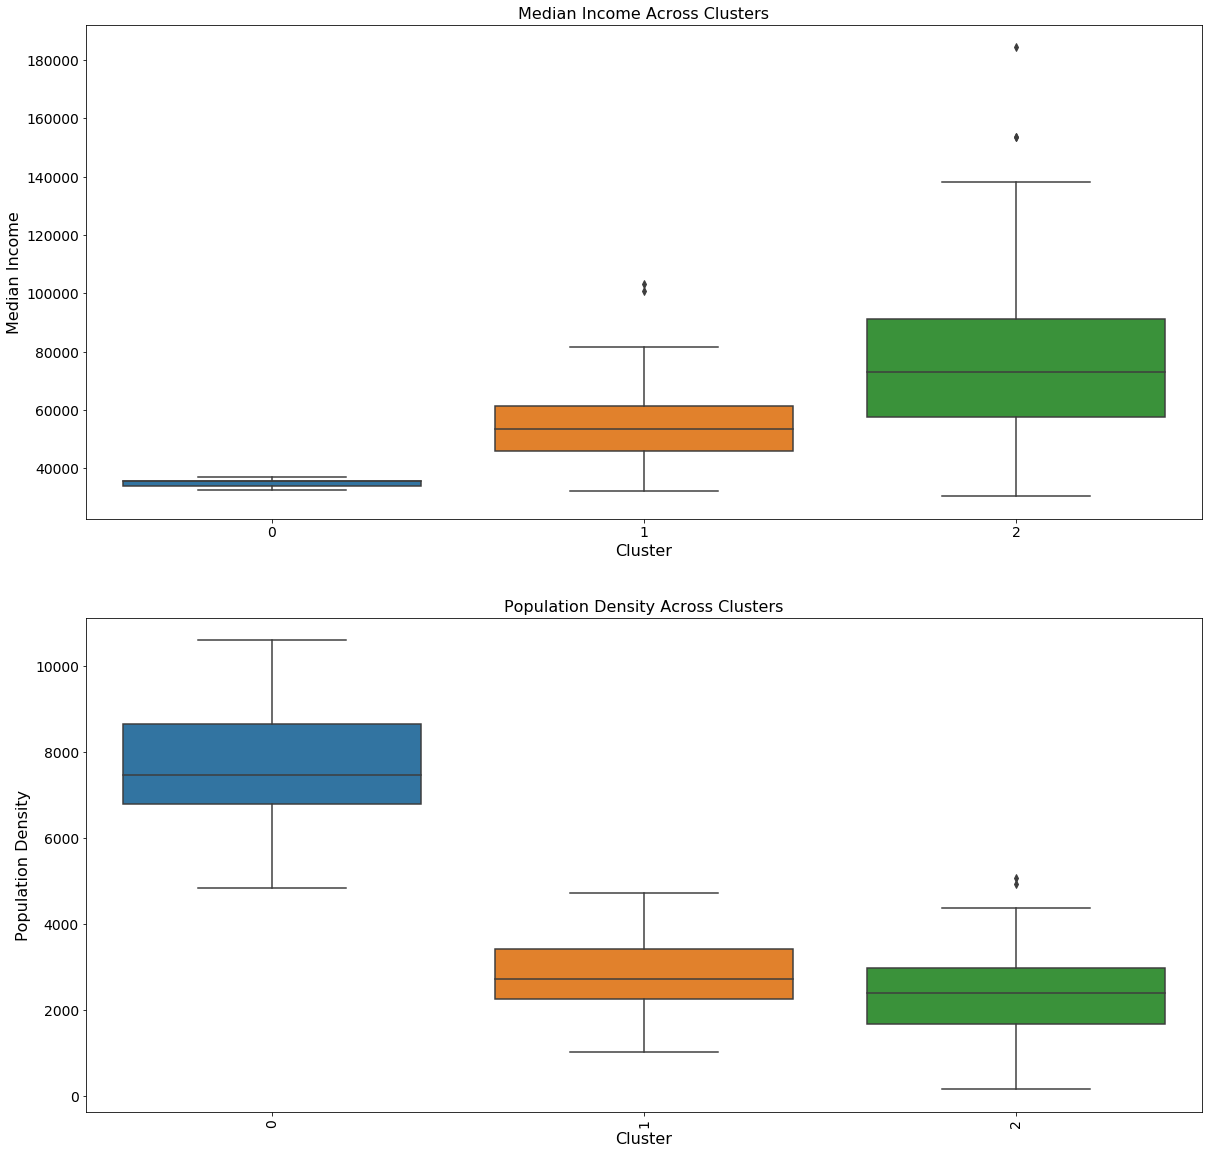

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.boxplot(x=cal_merged['Cluster Labels'], y=cal_merged['Med_Income'], ax = ax[0])
ax[0].tick_params(labelsize=14)
ax[0].set_title('Median Income Across Clusters', fontsize=16)
ax[0].set_xlabel('Cluster', fontsize=16)
ax[0].set_ylabel('Median Income', fontsize=16)

sns.boxplot(x=cal_merged['Cluster Labels'], y=cal_merged['Pop_Density'], ax = ax[1])
ax[1].tick_params(labelsize=14)
ax[1].set_title('Population Density Across Clusters', fontsize=16)
ax[1].set_xlabel('Cluster', fontsize=16)
ax[1].set_ylabel('Population Density', fontsize=16)

plt.xticks(rotation='vertical')

I remake the bar chart of the counts of venue categories per cluster. 

In cluster 0 the top 5 venue categories in order are:

1. Vietnamese Restaurants
2. Cafe's
3. Mexican Restaurants
4. Japanese Restaurants
5. Sandwich Places

In cluster 1 the top 5 venue categories in order are:

1. Fast Food Restaurants
2. Vietnamese Restaurants
3. Sandwich Places
4. Chinese Restaurants
5. Sushi Restaurants

In cluster 2 the top 5 venue categories in order are:

1. Sandwich Places
2. Cafe's
3. Fast Food Restaurants
4. Chinese Restaurants
5. Sushi Restaurants

There is still some overlap in the restaurant categories but it is a little more different than before. Each top category is different.

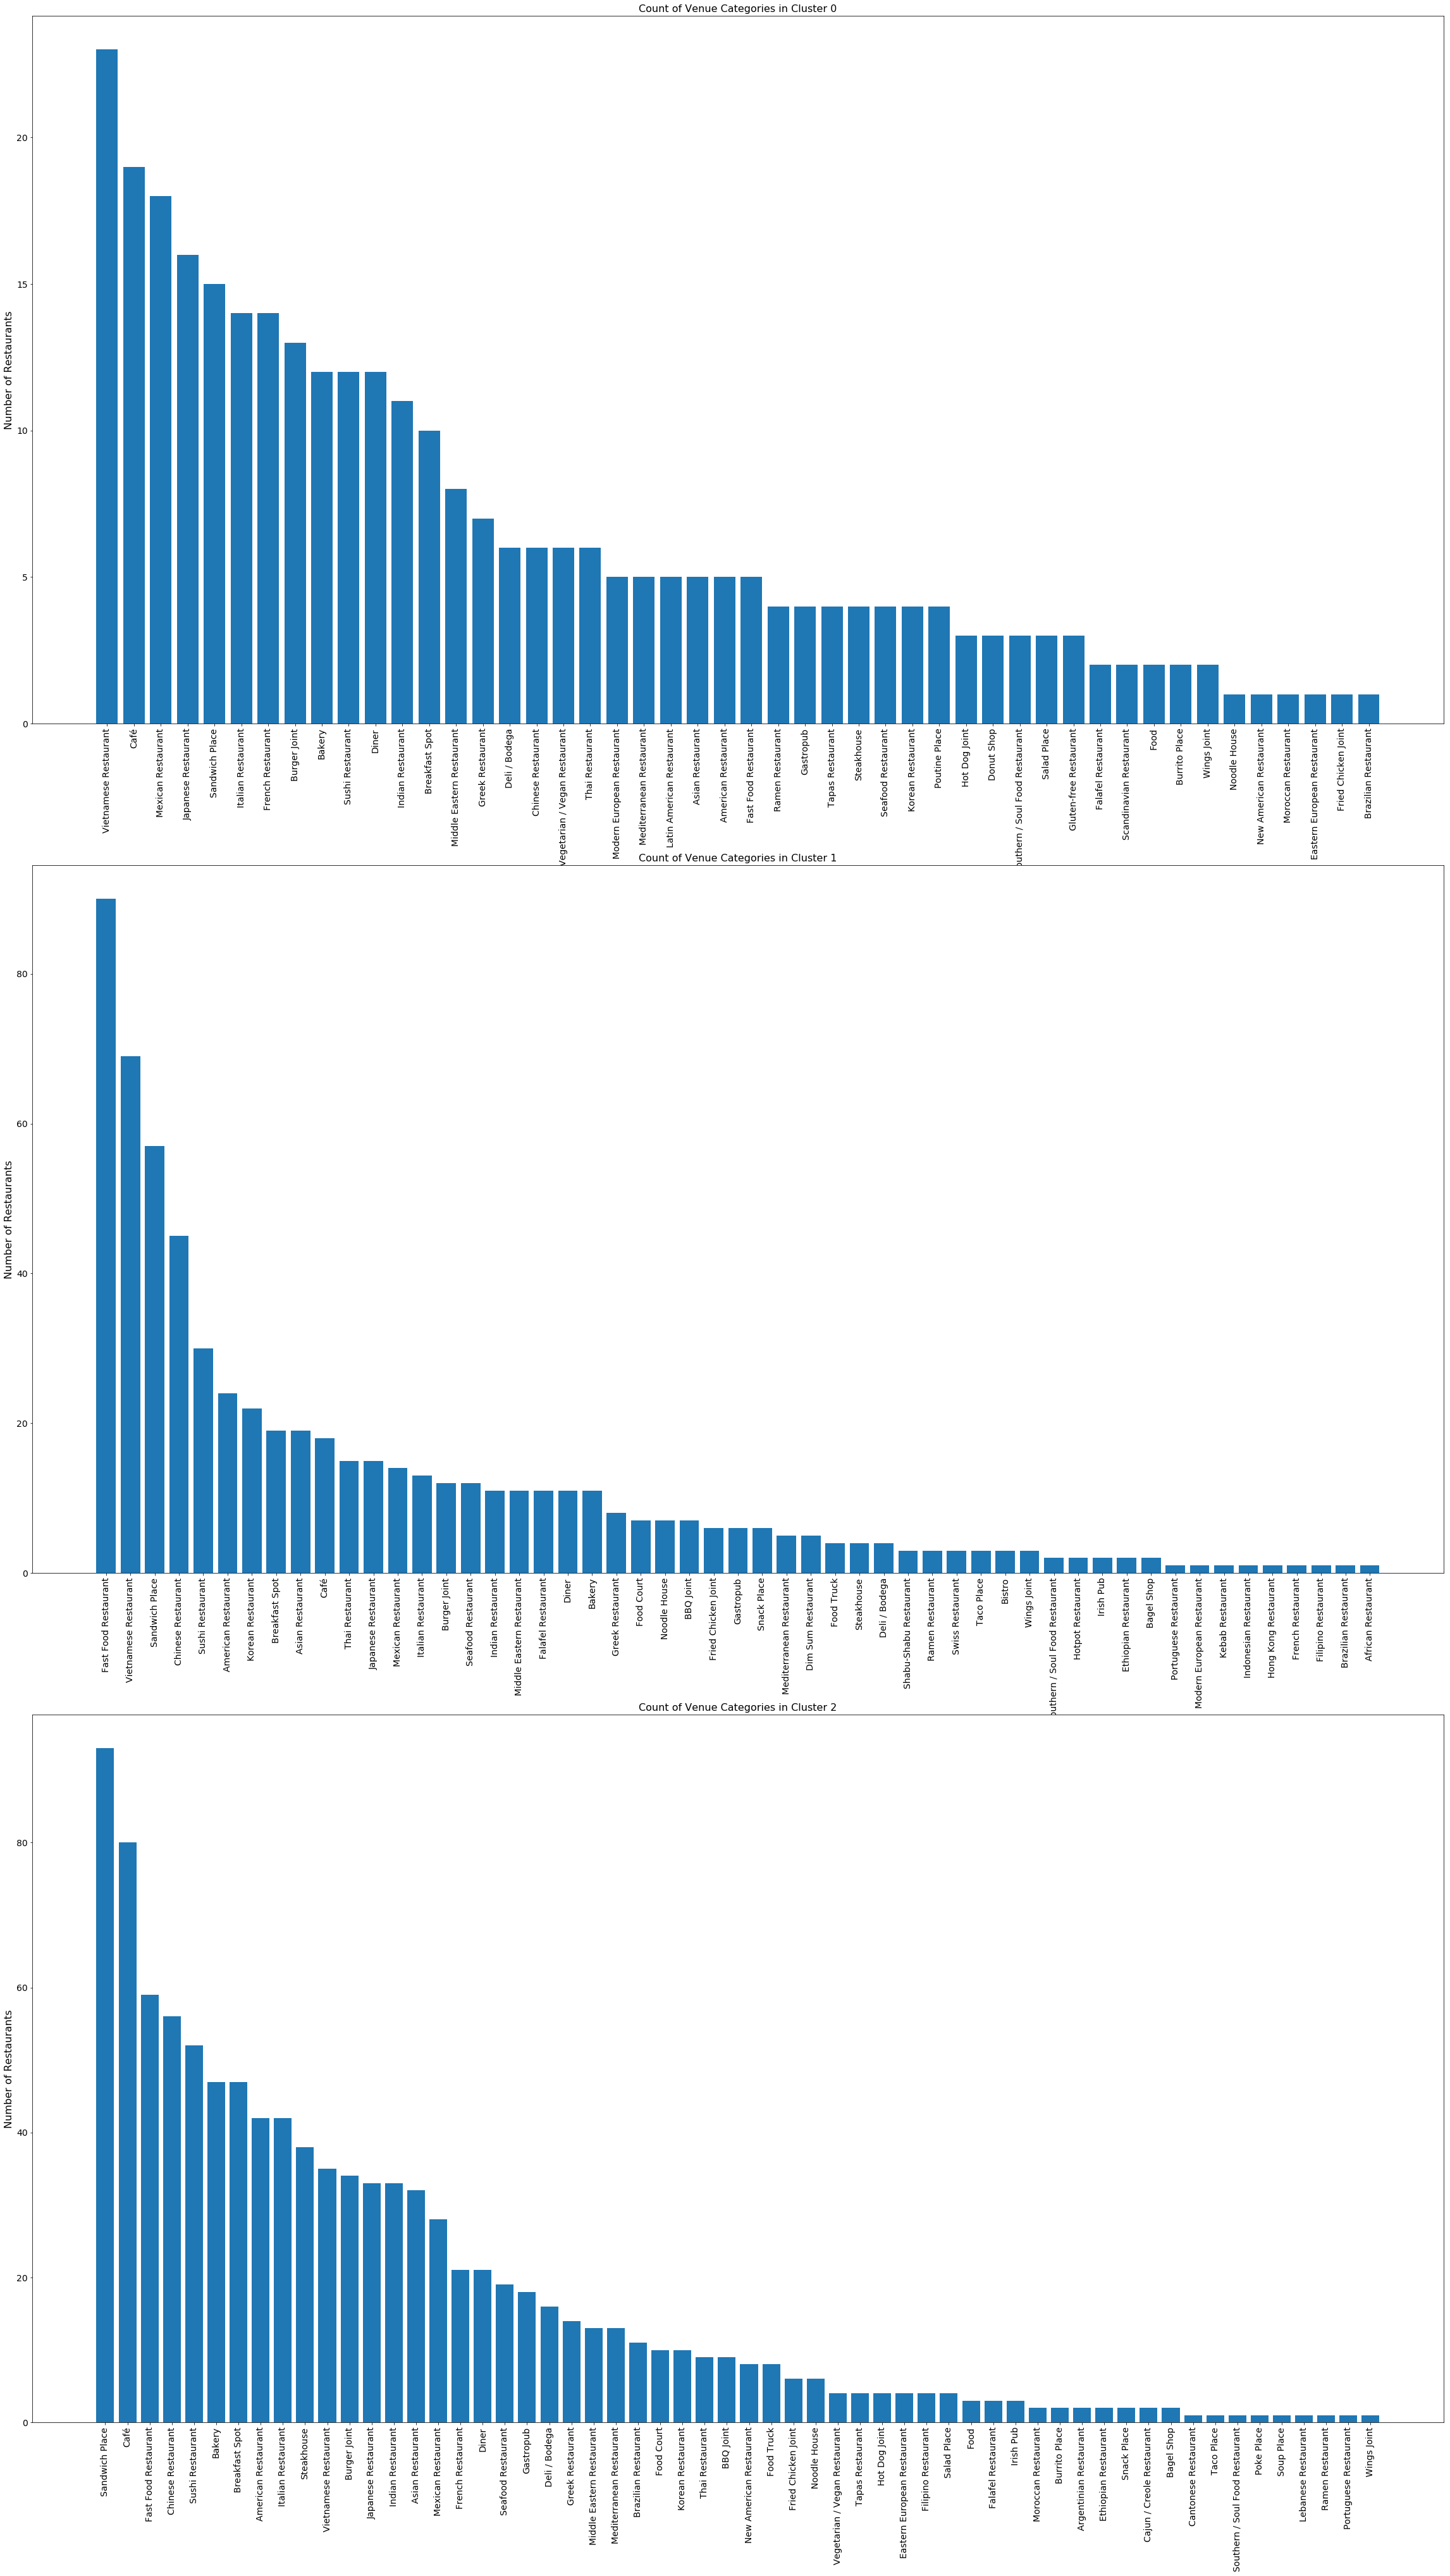

In [36]:
cluster_0_venues = cal_venues.set_index('Neighborhood').loc[cluster_0['Community']]
cluster_1_venues = cal_venues.set_index('Neighborhood').loc[cluster_1['Community']]
cluster_2_venues = cal_venues.set_index('Neighborhood').loc[cluster_2['Community']]

cluster_0_grouped = cluster_0_venues[['Venue Category', 'Venue']].groupby('Venue Category').count()
cluster_1_grouped = cluster_1_venues[['Venue Category', 'Venue']].groupby('Venue Category').count()
cluster_2_grouped = cluster_2_venues[['Venue Category', 'Venue']].groupby('Venue Category').count()

cluster_0_grouped.sort_values(by='Venue', ascending=False, inplace=True)
cluster_1_grouped.sort_values(by='Venue', ascending=False, inplace=True)
cluster_2_grouped.sort_values(by='Venue', ascending=False, inplace=True)

cluster_0_grouped.head()


x1 = np.arange(len(cluster_0_grouped.index))
x2 = np.arange(len(cluster_1_grouped.index))
x3 = np.arange(len(cluster_2_grouped.index))

fig, ax = plt.subplots(3,1, figsize=(40,70))

ax[0].bar(x1, cluster_0_grouped['Venue'])
ax[0].set_xticks(x1)
ax[0].set_xticklabels(cluster_0_grouped.index, rotation='vertical')
ax[0].tick_params(labelsize=14)
ax[0].set_title('Count of Venue Categories in Cluster 0', fontsize=16)
ax[0].set_ylabel('Number of Restaurants', fontsize=16)

ax[1].bar(x2, cluster_1_grouped['Venue'])
ax[1].set_xticks(x2)
ax[1].set_xticklabels(cluster_1_grouped.index, rotation='vertical')
ax[1].tick_params(labelsize=14)
ax[1].set_title('Count of Venue Categories in Cluster 1', fontsize=16)
ax[1].set_ylabel('Number of Restaurants', fontsize=16)

ax[2].bar(x3, cluster_2_grouped['Venue'])
ax[2].set_xticks(x3)
ax[2].set_xticklabels(cluster_2_grouped.index, rotation='vertical')
ax[2].tick_params(labelsize=14)
ax[2].set_title('Count of Venue Categories in Cluster 2', fontsize=16)
ax[2].set_ylabel('Number of Restaurants', fontsize=16)


plt.show()

### Evaluation of Clustering Using Classification Models

To evaluate the clustering from the K Means model, I test two classification models to see if each cluster can be predicted. I first split the data into train (80%) and test (20%) data. One important difference between the dataset used in the K Means algorithm and the dataset used in the classification algorithm is that the venue category feature was not used and instead replaced with the count of venues in each neighborhood. The reason for this is that there would be too many features if venue category was selected and the model would potentially overfit or run very slowly. 

The first model tested is a support vector machines model. This was selected because there are multiple features and the data set is small. 

In [42]:
from sklearn.model_selection import train_test_split

cal_merged3 = cal_merged2.join(neighborhoods_venues_sorted.set_index('Neighborhood'),
                                     on=cal_merged2.index)

cal_merged3.dropna(inplace=True)
features = cal_merged3[['Med_Income', 'Pop_Density', 'Venue Category']]
scaled = preprocessing.StandardScaler().fit_transform(features)


x = np.asarray(scaled)
y = np.asarray(cal_merged3['Cluster Labels'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (136, 3) (136,)
Test set: (35, 3) (35,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [43]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

yhat = clf.predict(X_test)
yhat

array([2., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 0.,
       2., 1., 1., 2., 2., 1., 2., 2., 2., 1., 2., 2., 1., 2., 2., 2., 2.,
       2.])

I then plot a confusion matrix to see how the model did with predicting the clusters. 

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The model did an excellent job at predicting cluster 2 with 20 out of 22 correct predictions. It did not do as well with clusters 0 and 1 however, where it predicted less than half correct for cluster 1 and half correct for cluster 0.

              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         2
         1.0       0.57      0.36      0.44        11
         2.0       0.74      0.91      0.82        22

   micro avg       0.71      0.71      0.71        35
   macro avg       0.77      0.59      0.64        35
weighted avg       0.70      0.71      0.69        35

Confusion matrix, without normalization
[[ 1  1  0]
 [ 0  4  7]
 [ 0  2 20]]


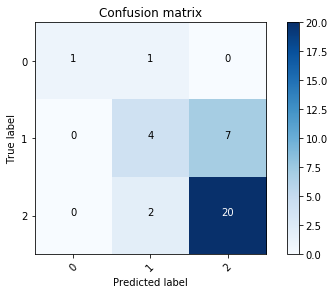

In [45]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2'],normalize= False,  title='Confusion matrix')

The train set accuracy is 68% and the test set accuracy is 71%. 

In [46]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.6838235294117647
Test set Accuracy:  0.7142857142857143


The second model I test is a K Nearest Neighbors model. A K value of 3 was found to work the best. The train set accuracy is 88% and the test set accuracy is 74%.

In [84]:
from sklearn.neighbors import KNeighborsClassifier

k = 3
  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

yhat = neigh.predict(X_test)

from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.875
Test set Accuracy:  0.7428571428571429


Looking at the confusion matrix, the KNN model seems to have done a better job than the SVM model. It predicted one less than the SVM model for cluster 2 but did better in both cluster 1 and cluster 0. It predicted all the correct labels in cluster 0. 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       0.62      0.45      0.53        11
         2.0       0.76      0.86      0.81        22

   micro avg       0.74      0.74      0.74        35
   macro avg       0.79      0.77      0.78        35
weighted avg       0.73      0.74      0.73        35

Confusion matrix, without normalization
[[ 2  0  0]
 [ 0  5  6]
 [ 0  3 19]]


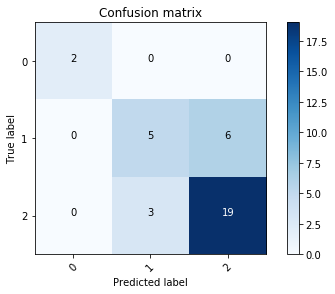

In [85]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2'],normalize= False,  title='Confusion matrix')

Since I used the same training and testing data for each model, I want to check the accuracy one step further. I check the cross validation score for each model with 4 folds. It seems that the models performed more or less the same overall. 

In [88]:
from sklearn.model_selection import cross_val_score
clf_cross_score = cross_val_score(clf, x, y, cv=4)
neigh_cross_score = cross_val_score(neigh, x, y, cv=4)

avg_score1=np.mean(clf_cross_score)
avg_score2=np.mean(neigh_cross_score)

print('SVM Score: {}, KNN Score: {}'.format(avg_score1, avg_score2))

SVM Score: 0.6842972918554314, KNN Score: 0.690658663042384


## RESULTS & CONCLUSION

The analysis was successful in answering the question of whether median income and population density has an effect on the number of restaurants in a neighborhood. The results show that as the median income decreases and the population density increases, the number of restaurants increases. 

The analysis was not successful in answering the question of whether these factors had an effect on the type of venues in an area. There was not a substantial difference in venue categories between clusters for the results to be satisfactory. 

One last thing that can be looked at is the percentage of neighborhoods and restaurants per cluster compared to the total amount in the city.

Cluster 0 represents about 3% of all the neighborhoods in the city but has 16% of the restaurants. These neighborhoods have the highest density of restaurants in the city.

Cluster 1 respresents about 32% of all the neighborhoods in the city and also 32% of all restaurants making it a 1:1 ratio. 

Cluster 2 has 64% of the neighborhoods in the city but 52% of the restaurants. These neighborhoods have the lowest density of restaurants in the city. 

In [113]:
no_v_0 = cluster_0_grouped['Venue'].sum()
no_v_1 = cluster_1_grouped['Venue'].sum()
no_v_2 = cluster_2_grouped['Venue'].sum()

total_v = no_v_0 + no_v_1 + no_v_2

no_0 = len(cluster_0)
no_1 = len(cluster_1)
no_2 = len(cluster_2)

total = no_0 + no_1 + no_2

v_0 = no_v_0/total_v
v_1 = no_v_1/total_v
v_2 = no_v_2/total_v

n_0 = no_0/total
n_1 = no_1/total
n_2 = no_2/total
print(no_2)
perc_dict = {'% of Total Neighborhoods': [n_0, n_1, n_2], '% of Total Restaurants': [v_0, v_1, v_2]}
ind = ['Cluster 0', 'Cluster 1', 'Cluster 2']
perc_df = pd.DataFrame(perc_dict, index=ind)
perc_df

110


,% of Total Neighborhoods,% of Total Restaurants
Cluster 0,0.029240,0.160832
Cluster 1,0.327485,0.322171
Cluster 2,0.643275,0.516996
